# Flu Shot Learning: Predicting H1N1 and Seasonal Flu Vaccines

The primary purpose of this notebook is to elucidate and critique the development of classification models predicting vaccination rates as well as answer two questions showing how the behavioral trends of individuals and groups influence their decision not to accept the H1N1 and Seasonal flu vaccines. 
Since vaccines are an effective way to hinder the spread of infectious diseases, understanding the reasons behind people's refusal to get them could be utilized to drive their acceptance. 

The data used is from a phone survey collecting information on whether individuals have received the two vaccines, as well as related factors contributing to the decision. After applying data cleaning and wrangling techniques, a multitude of multi-label classification models were implemented. 



## Importing requirements

In [2313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Encoding
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

#Visualisations
from pandas_profiling import ProfileReport
import missingno as mno

#Models
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance

#Parameter Search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Metrics
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


## Loading data

In [2314]:
#Loading the dataset containing trainining features
features = pd.read_csv("training_set_features.csv", index_col="respondent_id")

#Loading the dataset containing the labels
labels = pd.read_csv("training_set_labels.csv", index_col="respondent_id")

## Exploration

In [2315]:
#Returning the first five rows of the features dataframe for inspection
features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [2316]:
#Returning the last five rows of the features dataframe for inspection
features.tail()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg
26706,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,mlyzmhmf,"MSA, Principle City",1.0,0.0,NaN,NaN


In [2317]:
#Returning the 10 rows from the middle of the features dataframe with iloc
features.iloc[13347:13357]

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
13347,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,atmpeygn,"MSA, Not Principle City",1.0,3.0,NaN,NaN
13348,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,NaN,Married,Rent,Not in Labor Force,lzgpxyit,Non-MSA,3.0,1.0,NaN,NaN
13349,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"> $75,000",Married,Own,Not in Labor Force,kbazzjca,Non-MSA,1.0,3.0,NaN,NaN
13350,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,"MSA, Principle City",1.0,0.0,NaN,NaN
13351,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,oxchjgsf,"MSA, Not Principle City",1.0,1.0,NaN,NaN
13352,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,qufhixun,"MSA, Principle City",1.0,2.0,fcxhlnwr,xtkaffoo
13353,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,NaN,Married,Own,Employed,kbazzjca,Non-MSA,1.0,0.0,fcxhlnwr,xgwztkwe
13354,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,dqpwygqj,Non-MSA,1.0,1.0,dotnnunm,xgwztkwe
13355,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Rent,Unemployed,mlyzmhmf,"MSA, Principle City",1.0,1.0,NaN,NaN


In [2318]:
#Returning the first five rows of the labels dataframe for inspection
labels.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [2319]:
#Returning the data type of each column in the features dataframe
features.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [2320]:
#Printing a summary of the features dataframe
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

The dataset used consists of 26,707 responses and 35 features

We can see the data types available for this dataset are 25 instances of floats, 1 integer and 12 objects.

In [2321]:
#Generating a statistical summary of the numerical columns in the features dataframe
features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
h1n1_concern,26615.0,1.618486,0.910311,0.0,1.0,2.0,2.0,3.0
h1n1_knowledge,26591.0,1.262532,0.618149,0.0,1.0,1.0,2.0,2.0
behavioral_antiviral_meds,26636.0,0.048844,0.215545,0.0,0.0,0.0,0.0,1.0
behavioral_avoidance,26499.0,0.725612,0.446214,0.0,0.0,1.0,1.0,1.0
behavioral_face_mask,26688.0,0.068982,0.253429,0.0,0.0,0.0,0.0,1.0
behavioral_wash_hands,26665.0,0.825614,0.379448,0.0,1.0,1.0,1.0,1.0
behavioral_large_gatherings,26620.0,0.358640,0.479610,0.0,0.0,0.0,1.0,1.0
behavioral_outside_home,26625.0,0.337315,0.472802,0.0,0.0,0.0,1.0,1.0
behavioral_touch_face,26579.0,0.677264,0.467531,0.0,0.0,1.0,1.0,1.0
doctor_recc_h1n1,24547.0,0.220312,0.414466,0.0,0.0,0.0,0.0,1.0


In [2322]:
#We concatenate both features and labels into a dataframe called data_profile
data_profile = pd.concat([features, labels])

In [2323]:
#We generate a profilling report for the concatenated dataframe
#The report will include information such as correlations, summaries and visualizations
profile = ProfileReport(data_profile, title="H1N1 and Seasonal Flu Vaccines")
#profile

Profile is currently commented as we only required it to be run once and it takes quite some time, however, the function was useful for quickly understanding the characteristics of the dataset and has been used as a starting point for further exploratory data analysis.

## Pre-Processing

### Checking Duplicates

In [2324]:
#Checking for duplicates
features.duplicated().sum()

0

There are no duplicates in this dataset

### Checking Missing Data

In [2325]:
#Checking if any missing values exist in the data with a True/False output
features.isnull().any()

h1n1_concern                    True
h1n1_knowledge                  True
behavioral_antiviral_meds       True
behavioral_avoidance            True
behavioral_face_mask            True
behavioral_wash_hands           True
behavioral_large_gatherings     True
behavioral_outside_home         True
behavioral_touch_face           True
doctor_recc_h1n1                True
doctor_recc_seasonal            True
chronic_med_condition           True
child_under_6_months            True
health_worker                   True
health_insurance                True
opinion_h1n1_vacc_effective     True
opinion_h1n1_risk               True
opinion_h1n1_sick_from_vacc     True
opinion_seas_vacc_effective     True
opinion_seas_risk               True
opinion_seas_sick_from_vacc     True
age_group                      False
education                       True
race                           False
sex                            False
income_poverty                  True
marital_status                  True
r

<AxesSubplot: >

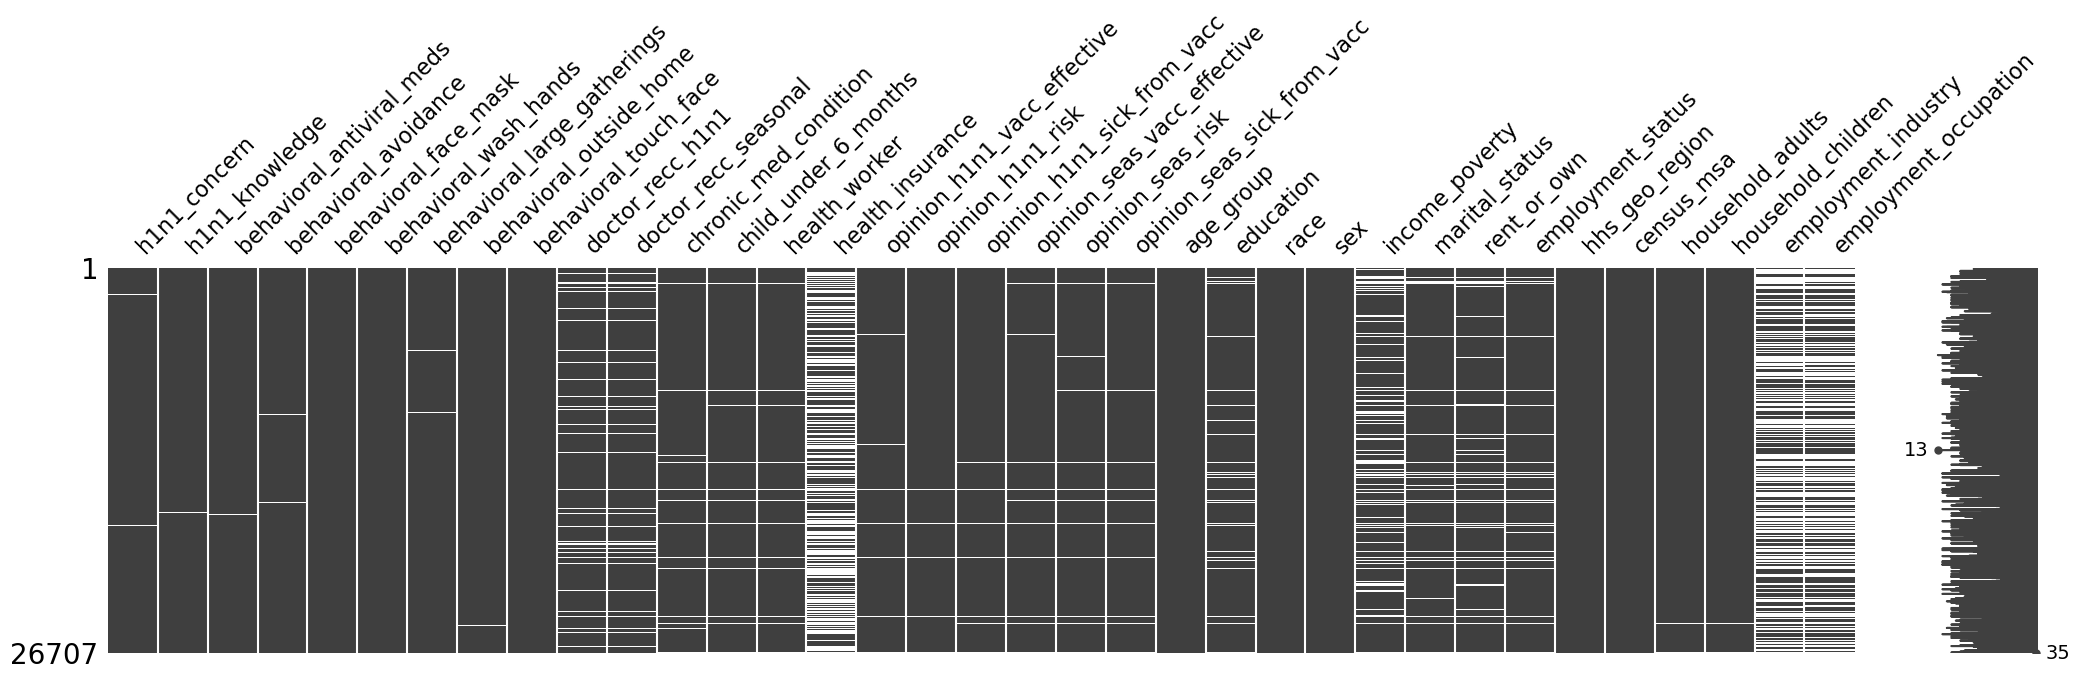

In [2326]:
#Creating a visual representation of the missing values in the features dataframe
mno.matrix(features, figsize = (25, 5))

A matrix plot has been created, the plot shows missing values as white spaces so the larger the white spaces, the more missing values are present in a given column. 

In this case, we can see that health_insurance, employment_industry and employment_occupation are heavily dispersed with white spaces, indicating the huge number of null values in comparison to other columns. 

We can statistically calculate the percentage below.

In [2327]:
#We calculate the percentage of missing values in each column of the features dataframe
missing_data = features.isnull().sum()/len(features)*100

#We sort the series into descending order based on the percentages
missing_data.sort_values(ascending=False)

employment_occupation          50.436215
employment_industry            49.912008
health_insurance               45.957989
income_poverty                 16.561201
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
rent_or_own                     7.645936
employment_status               5.477965
marital_status                  5.272026
education                       5.268282
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
opinion_seas_sick_from_vacc     2.010709
opinion_seas_risk               1.924589
opinion_seas_vacc_effective     1.729884
opinion_h1n1_sick_from_vacc     1.479013
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
household_children              0.932340
household_adults                0.932340
behavioral_avoidance            0.778822
behavioral_touch_face           0.479275
h1n1_knowledge                  0.434343
h1n1_concern    

We can see that the following features have over 40% of missing data so we can drop them:
- employment_occupation
- employment_industry
- health_insurance

In [2328]:
#We drop the features specificed from the original dataframe, and output the first 5 rows to verify that they aren't present 
features.drop(["health_insurance", "employment_industry", "employment_occupation"], axis = 1, inplace = True)
features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0


### Imputation and Encoding pipeline

We will impute and encode the rest of the data using a pipeline

In [2329]:
#We assign each feature to its respective type of data for specific imputation strategies created in the pipeline
categorical_columns = [
    'race',
    'sex',
    'marital_status',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'rent_or_own',
]


ordinal_numeric_columns = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'household_adults',
    'household_children',
]


ordinal_object_columns = [
    'age_group',
    'education',
    'income_poverty',
]


boolean_columns = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance', 
    'behavioral_face_mask', 
    'behavioral_wash_hands',
    'behavioral_large_gatherings', 
    'behavioral_outside_home',
    'behavioral_touch_face', 
    'doctor_recc_h1n1', 
    'doctor_recc_seasonal',
    'chronic_med_condition', 
    'child_under_6_months', 
    'health_worker',
]


In [2330]:
# Preprocessing pipeline for categorical_columns
# This step applies one-hot encoding to the categorical features where each column represents a unique category
# The sparse_output parameter ensures that the encoded data is in a dense matrix format
category_preprocessor = make_pipeline(
    OneHotEncoder(drop='first', sparse_output=False), 
)

# Preprocessing pipeline for ordinal and object features
# This step performs ordinal encoding, which assigns unique integer values to each category within ordinal or object features.
# This encoding preserves the order of the categories.
# This step also handles missing values in the encoded features. It replaces missing values with a constant value of -1
# By using -1 as a fill value, we preserserve the data and ensure that we avoid bias for the ordinal_object_columns
ordinal_object_preprocessor = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='constant', fill_value = -1),
)


In [2331]:
# Creating the default data preprocessing pipeline by combining the two previous pipelines
default_preprocessor = ColumnTransformer(
    transformers=[
        ('boolean_imputer', SimpleImputer(strategy='most_frequent'), boolean_columns),
        ('ordinal_numeric_imputer', SimpleImputer(strategy='median'), ordinal_numeric_columns),
        ('ordinal_object_preprocessor', ordinal_object_preprocessor, ordinal_object_columns),
        ('category_preprocessor', category_preprocessor, categorical_columns),
        
    ],
    remainder='passthrough'
)
# The remainder parameter specifies that any remaining columns in the dataset that were not explicitly mentioned
# in the transformations should be passed through without any transformations.
default_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('boolean_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1',
                                  'doctor_recc_seasonal',
                                  'chronic_med_c...
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder()),
                                                 ('simpleimputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant'))]),
                                 ['age_group', 'education', 'income_poverty']),
                                ('category_preprocessor',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['race', 'sex', 'marital_status',
                                  'employment_status', 'hhs_geo_region',
                                  'census_msa', 'rent_or_own'])])

The default_preprocessor pipeline can now be used in conjunction with the models created after visualisation to preprocess the data and apply the spefcified transoformations to the data before feeding it into the models for tranining and prediction.

#### Old Code for impuation and encoding

In [2332]:
"""
#Assigning nominal data to a list
nominals = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
             'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
               'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition',
                 'child_under_6_months', 'health_worker', 'race', 'sex', 'marital_status',
                   'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa']


#Assigning ordinal data to a list
ordinals = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
             'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
               'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty', 'household_adults', 'household_children']
"""

"\n#Assigning nominal data to a list\nnominals = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',\n             'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',\n               'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition',\n                 'child_under_6_months', 'health_worker', 'race', 'sex', 'marital_status',\n                   'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa']\n\n\n#Assigning ordinal data to a list\nordinals = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',\n             'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk',\n               'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty', 'household_adults', 'household_children']\n"

In [2333]:
"""
#We create a transformer that applies one hot encoding to our nominal values while it also standarises and imputes missing data using the median strategy
col_transformer = make_column_transformer(
    (OneHotEncoder(), nominals),
    (make_pipeline(OrdinalEncoder(), StandardScaler(), SimpleImputer(strategy='median', add_indicator=True)), ordinals))

col_transformer
"""

"\n#We create a transformer that applies one hot encoding to our nominal values while it also standarises and imputes missing data using the median strategy\ncol_transformer = make_column_transformer(\n    (OneHotEncoder(), nominals),\n    (make_pipeline(OrdinalEncoder(), StandardScaler(), SimpleImputer(strategy='median', add_indicator=True)), ordinals))\n\ncol_transformer\n"

In [2334]:
"""
#Assigning the numerical data to a variable
numeric = features.select_dtypes(exclude="object").columns
"""

'\n#Assigning the numerical data to a variable\nnumeric = features.select_dtypes(exclude="object").columns\n'

In [2335]:

"""
##Imputation of the Numerical Data using median
for column in numeric:
    features[column].fillna(features[column].median(), inplace= True)
"""

'\n##Imputation of the Numerical Data using median\nfor column in numeric:\n    features[column].fillna(features[column].median(), inplace= True)\n'

In [2336]:
"""
#In order to use the knn imputer, the data should be normalised to avoid biased replacements
#This is due to the knn imputation being distance-based
scaler = MinMaxScaler()
numeric_data = pd.DataFrame(scaler.fit_transform(numeric), columns = numeric.columns)
numeric_data.head()
"""

'\n#In order to use the knn imputer, the data should be normalised to avoid biased replacements\n#This is due to the knn imputation being distance-based\nscaler = MinMaxScaler()\nnumeric_data = pd.DataFrame(scaler.fit_transform(numeric), columns = numeric.columns)\nnumeric_data.head()\n'

In [2337]:
"""
##Imputation of the Numerical Data using knn
knn_imputer = knnImputer(n_neighbors=5)

for column in numeric:
    features[column];knn_imputer.fit_transform(numeric_data)
"""

'\n##Imputation of the Numerical Data using knn\nknn_imputer = knnImputer(n_neighbors=5)\n\nfor column in numeric:\n    features[column];knn_imputer.fit_transform(numeric_data)\n'

In [2338]:
"""
missing_data = features.isnull().sum()/len(features)*100
missing_data.sort_values(ascending=False)

#We've now replaced the numerical data missing data with the means of the K-nearest Neighbor values
"""

"\nmissing_data = features.isnull().sum()/len(features)*100\nmissing_data.sort_values(ascending=False)\n\n#We've now replaced the numerical data missing data with the means of the K-nearest Neighbor values\n"

## Visualization

### Checking if the dataset is balanced

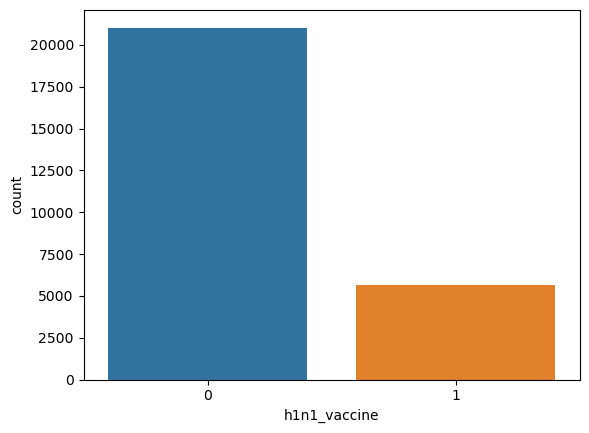

In [2339]:
# Create a count plot to visualize the distribution of h1n1_vaccine values
sns.countplot(x="h1n1_vaccine", data=labels);

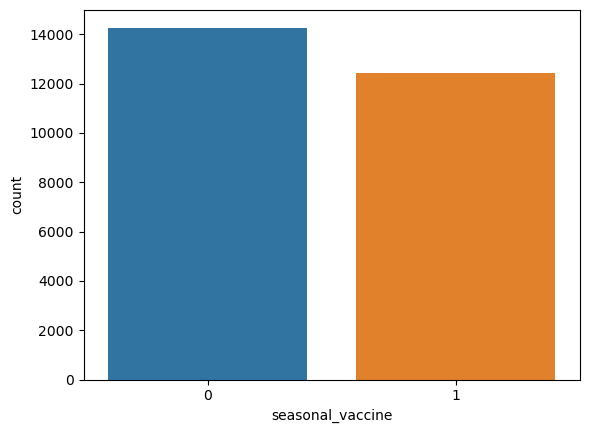

In [2340]:
# Create a count plot to visualize the distribution of seasonal_vaccine values
sns.countplot(x="seasonal_vaccine", data=labels);

We can note that most people were not worried about the risk of H1N1

### Distribution Graphs

In [2341]:
# Combine the features and labels dataframes into a new dataframe
combined_df = features.join(labels)

# Display the first few rows of the combined dataframe
combined_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0


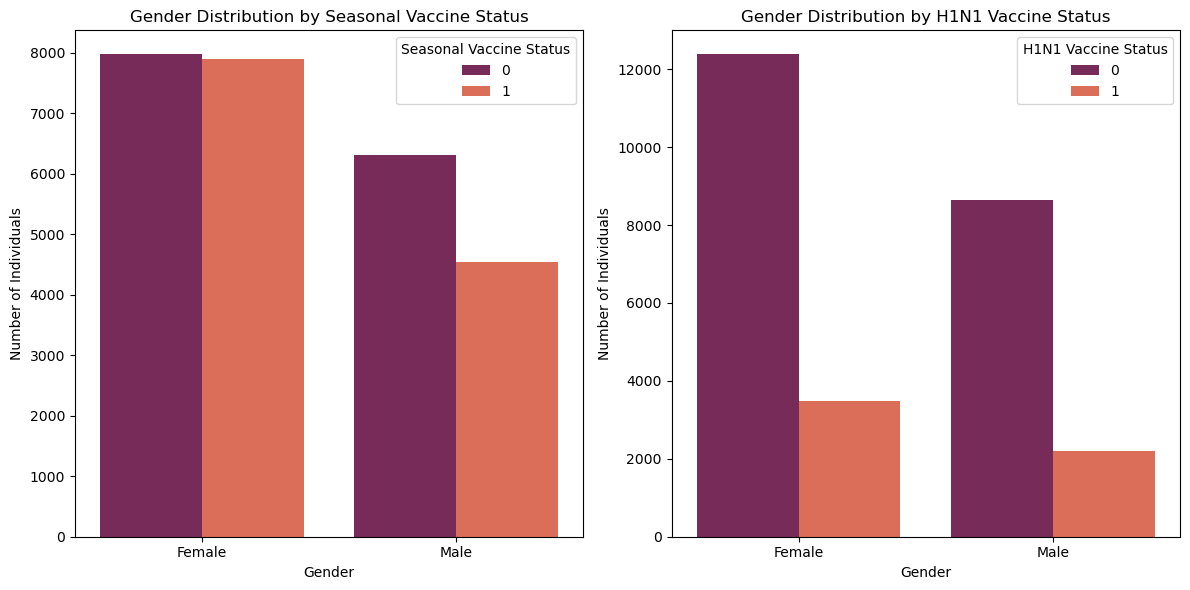

In [2342]:
# Group the data by gender and vaccination status for seasonal vaccine
seasonal_vaccine = combined_df.groupby(['sex', 'seasonal_vaccine']).size().unstack(fill_value=0)

# Reset the index of the grouped dataframe
seasonal_vaccine = seasonal_vaccine.reset_index()

# Melting the dataframe to make it suitable for visualization
melted_seasonal = pd.melt(seasonal_vaccine, id_vars=['sex'], var_name='vaccine_status', value_name='count')

# Group the data by gender and vaccination status for H1N1 vaccine
h1n1_vaccine = combined_df.groupby(['sex', 'h1n1_vaccine']).size().unstack(fill_value=0)

# Reset the index of the grouped dataframe
h1n1_vaccine = h1n1_vaccine.reset_index()

# Melt the dataframe to make it suitable for visualization
melted_h1n1 = pd.melt(h1n1_vaccine, id_vars=['sex'], var_name='vaccine_status', value_name='count')

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Create a stacked bar chart to visualize the distribution of gender by vaccination status for seasonal vaccine
sns.barplot(x='sex', y='count', hue='vaccine_status', data=melted_seasonal, palette='rocket', ax=axs[0])

# Set the chart title and axis labels
axs[0].set_title('Gender Distribution by Seasonal Vaccine Status')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Number of Individuals')

# Add a legend to the chart
axs[0].legend(title='Seasonal Vaccine Status')

# Create a stacked bar chart to visualize the distribution of gender by vaccination status for H1N1 vaccine
sns.barplot(x='sex', y='count', hue='vaccine_status', data=melted_h1n1, palette='rocket', ax=axs[1])

# Set the chart title and axis labels
axs[1].set_title('Gender Distribution by H1N1 Vaccine Status')
axs[1].set_xlabel('Gender')
axs[1].set_ylabel('Number of Individuals')

# Add a legend to the chart
axs[1].legend(title='H1N1 Vaccine Status')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the chart
plt.show()

<AxesSubplot: title={'center': 'Stacked bar plot of genders accepting and refusing the H1N1 vaccine'}, xlabel='h1n1_vaccine'>

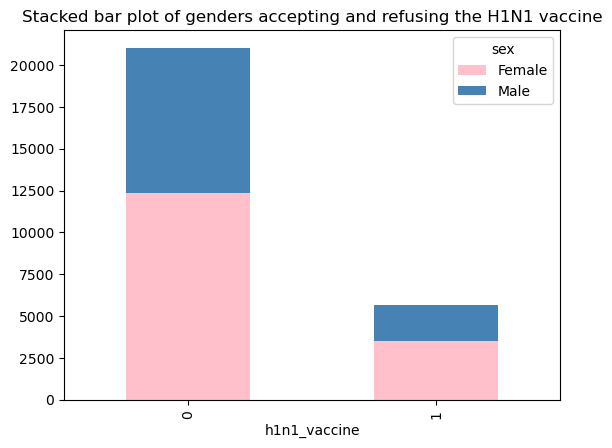

In [2343]:
#Creating a stacked bar chart for the vaccines to show the acceptance and refusal for the vaccine rather than by gender
combined_df.groupby(['h1n1_vaccine', 'sex']).size().unstack().plot(kind='bar', stacked=True, color=['pink','steelblue'], title='Stacked bar plot of genders accepting and refusing the H1N1 vaccine')

<AxesSubplot: title={'center': 'Stacked bar plot of genders accepting and refusing the Seasonal Flu vaccine'}, xlabel='seasonal_vaccine'>

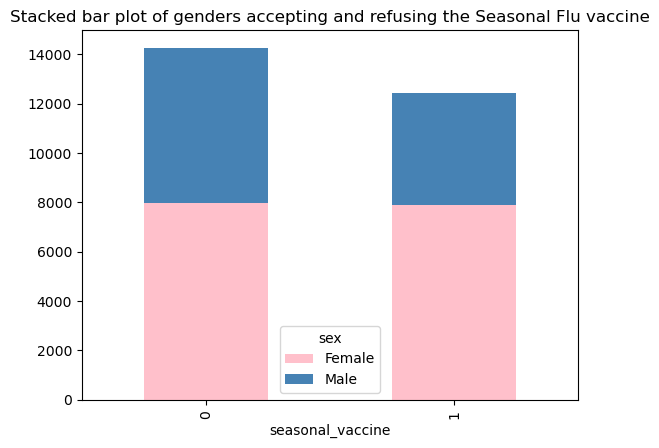

In [2344]:
# Create a stacked bar plot showing the count of genders accepting and refusing the Seasonal Flu vaccine
combined_df.groupby(['seasonal_vaccine', 'sex']).size().unstack().plot(kind='bar', stacked=True, color=['pink','steelblue'], 
title='Stacked bar plot of genders accepting and refusing the Seasonal Flu vaccine')

From the 3 bar charts above we can conclude that the Seasonal Vaccine is accepted more often than the H1N1 vaccine. Another conclusion is that women tend to accept both vaccines more often than men.

In [2345]:
"""
The function bellow is a visualisation technique gathered from the driven data article
regarding the same dataset @https://drivendata.co/blog/predict-flu-vaccine-data-benchmark/
"""
def vaccination_rate_plot(col, target, combined_df, ax=None):
    counts = (combined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

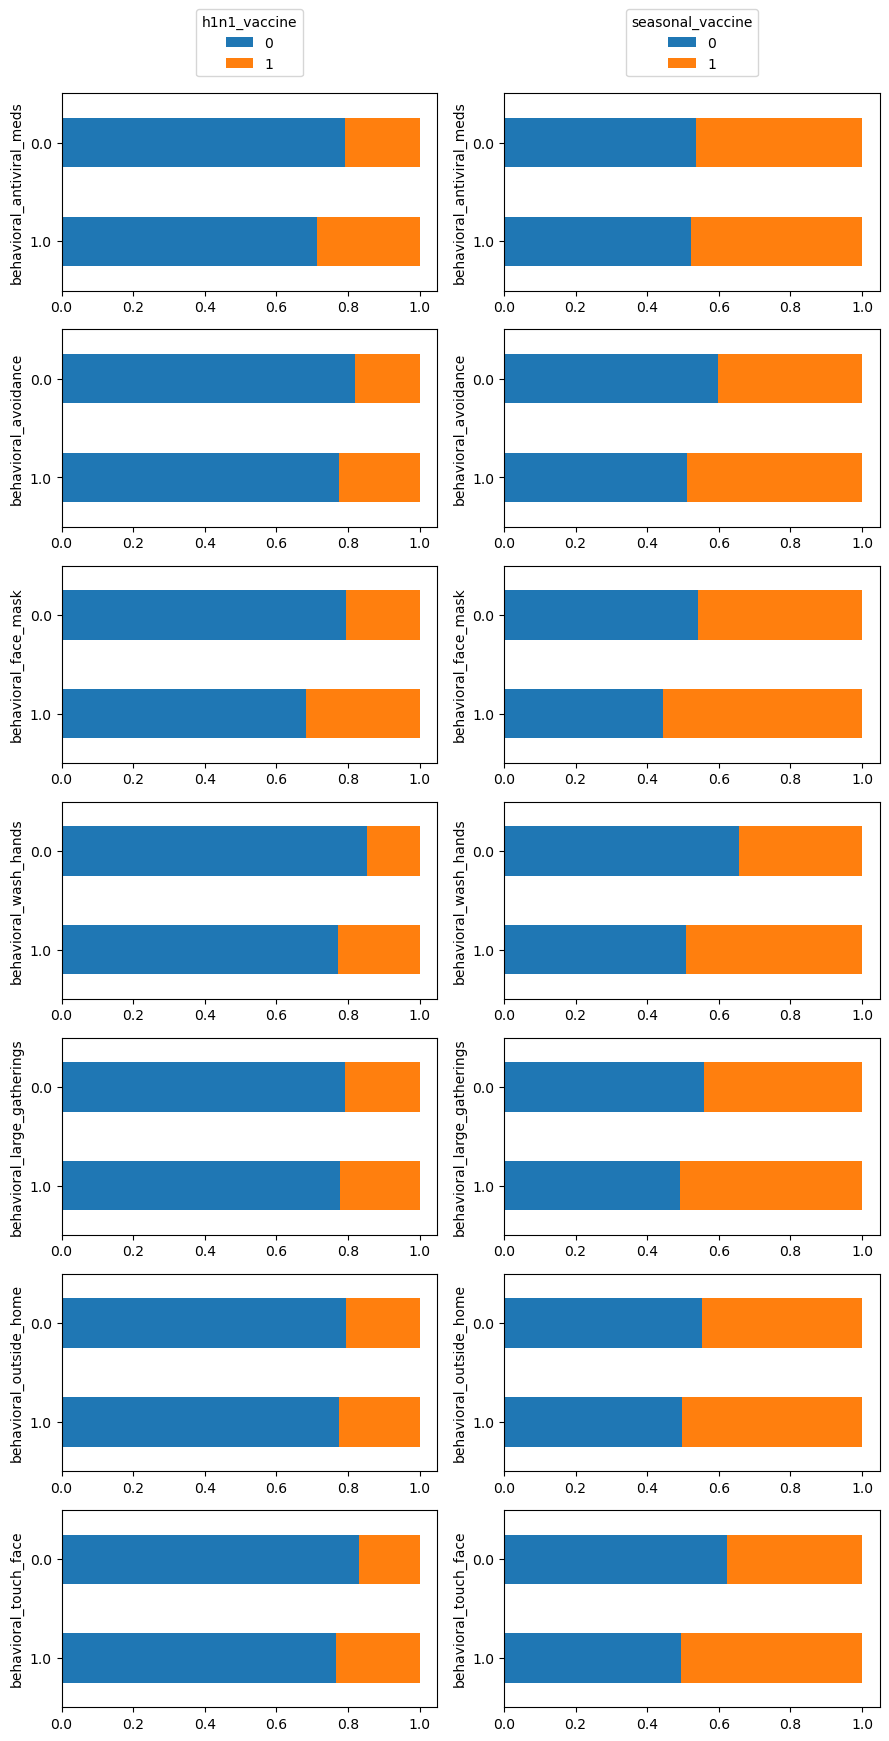

In [2346]:
"""
The function bellow is a visualisation technique gathered from the driven data article
regarding the same dataset @https://drivendata.co/blog/predict-flu-vaccine-data-benchmark/
"""
columns_to_plot = ["behavioral_antiviral_meds",
                    "behavioral_avoidance",
                    "behavioral_face_mask",
                    "behavioral_wash_hands",
                    "behavioral_large_gatherings",
                    "behavioral_outside_home",
                    "behavioral_touch_face"]       

fig, ax = plt.subplots(
    len(columns_to_plot), 2, figsize=(9,len(columns_to_plot)*2.5)
)
for idx, col in enumerate(columns_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', combined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', combined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

In [2347]:
slices_to_plot = np.array(features[["behavioral_antiviral_meds",
                    "behavioral_avoidance",
                    "behavioral_face_mask",
                    "behavioral_wash_hands",
                    "behavioral_large_gatherings",
                    "behavioral_outside_home",
                    "behavioral_touch_face"]].sum())

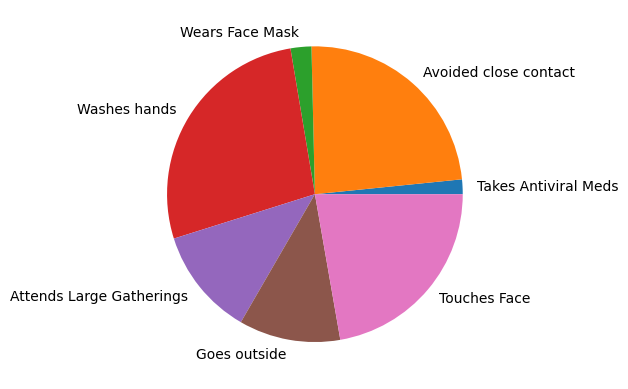

In [2348]:
# Define a list of behavioral features
behavioral_slices = ["Takes Antiviral Meds", "Avoided close contact", "Wears Face Mask", "Washes hands", "Attends Large Gatherings", "Goes outside", "Touches Face"]

# Create a pie chart to visualize the distribution of slices
plt.pie(slices_to_plot, labels = behavioral_slices)

#Displays the pie chart
plt.show()

### Visualising outliers

In [2349]:
def find_outliers_IQR(features):
# Calculate the first quartile (Q1)
   q1=features.quantile(0.25)
# Calculate the third quartile (Q3)
   q3=features.quantile(0.75)
# Calculate the Interquartile Range (IQR)
   IQR=q3-q1
# Identify outliers based on the IQR range
   outliers = features[((features<(q1-1.5*IQR)) | (features>(q3+1.5*IQR)))]
# Return the outliers
   return outliers

In [2350]:
# Identify outliers using the find_outliers_IQR() function and assign them to the 'outliers' variable
outliers = find_outliers_IQR(features)

# Print the number of outliers by converting the length of the 'outliers' variable to a string
print("number of outliers:" + str(len(outliers)))

# Print the maximum value among the outliers by converting it to a string
print("max outlier value:" + str(outliers.max()))

# Print the minimum value among the outliers by converting it to a string
print("min outlier value:" + str(outliers.min()))

# Display the outliers
outliers

C:\Users\danie\AppData\Local\Temp\ipykernel_28068\10365664.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1=features.quantile(0.25)
C:\Users\danie\AppData\Local\Temp\ipykernel_28068\10365664.py:5: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3=features.quantile(0.75)
C:\Users\danie\AppData\Local\Temp\ipykernel_28068\10365664.py:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = features[((features<(q1-1.5*IQR)) | (features>(q3+1.5*IQR)))]


number of outliers:26707
max outlier value:h1n1_concern                    NaN
h1n1_knowledge                  NaN
behavioral_antiviral_meds       1.0
behavioral_avoidance            NaN
behavioral_face_mask            1.0
behavioral_wash_hands           0.0
behavioral_large_gatherings     NaN
behavioral_outside_home         NaN
behavioral_touch_face           NaN
doctor_recc_h1n1                1.0
doctor_recc_seasonal            NaN
chronic_med_condition           NaN
child_under_6_months            1.0
health_worker                   1.0
opinion_h1n1_vacc_effective     NaN
opinion_h1n1_risk               NaN
opinion_h1n1_sick_from_vacc     NaN
opinion_seas_vacc_effective     2.0
opinion_seas_risk               NaN
opinion_seas_sick_from_vacc     NaN
age_group                      None
education                      None
race                           None
sex                            None
income_poverty                 None
marital_status                 None
rent_or_own          

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26704,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

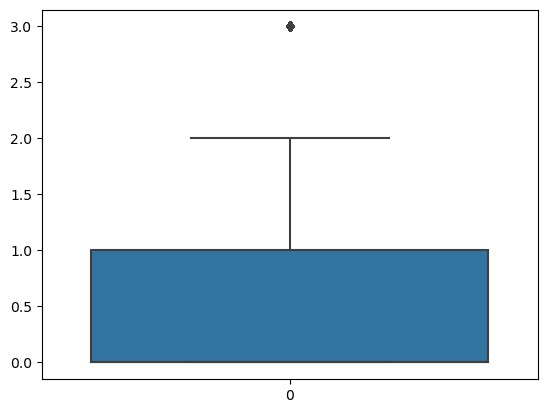

In [2351]:
# Create a box plot of the "household_children" column to visualise the outliers
sns.boxplot(features.household_children)

<AxesSubplot: xlabel='household_children', ylabel='count'>

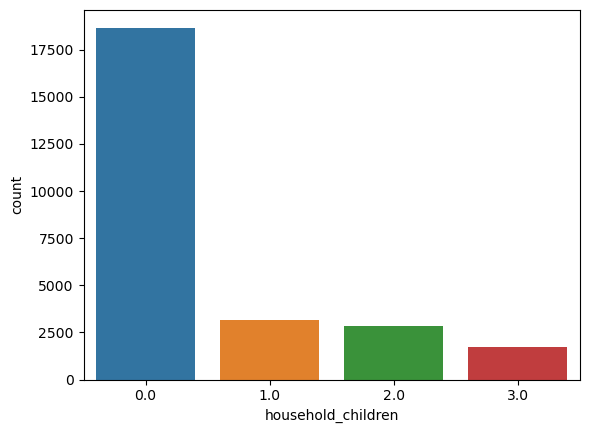

In [2352]:
# Create a count plot of the "household_children" column to visualise the outliers
sns.countplot(x=combined_df["household_children"])

<AxesSubplot: >

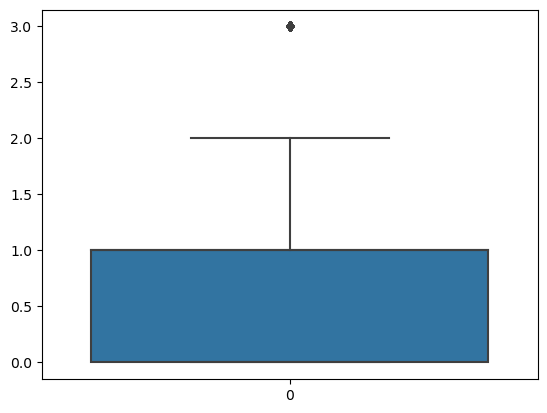

In [2353]:
# Create a box plot of the "household_adults" column to visualise the outliers
sns.boxplot(features.household_adults)

<AxesSubplot: xlabel='household_adults', ylabel='count'>

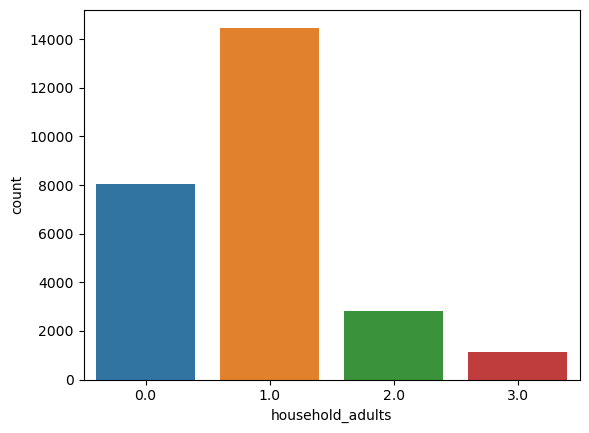

In [2354]:
# Create a count plot based on the "household_adults" column in the "combined_df" dataframe to visualise the outliers
sns.countplot(x=combined_df["household_adults"])

The outliers seem to be missrepresented data so we decide not to remove them as that would lower the accuracy when dealing with unseen data

### Correlation

In [2355]:
#Correlation of features to H1N1
features.corrwith(labels.h1n1_vaccine)

C:\Users\danie\AppData\Local\Temp\ipykernel_28068\1831096868.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features.corrwith(labels.h1n1_vaccine)


h1n1_concern                   0.121929
h1n1_knowledge                 0.117951
behavioral_antiviral_meds      0.040608
behavioral_avoidance           0.047690
behavioral_face_mask           0.070498
behavioral_wash_hands          0.074712
behavioral_large_gatherings    0.017822
behavioral_outside_home        0.021768
behavioral_touch_face          0.071648
doctor_recc_h1n1               0.393890
doctor_recc_seasonal           0.209864
chronic_med_condition          0.095207
child_under_6_months           0.066962
health_worker                  0.169768
opinion_h1n1_vacc_effective    0.269347
opinion_h1n1_risk              0.323265
opinion_h1n1_sick_from_vacc    0.075091
opinion_seas_vacc_effective    0.179272
opinion_seas_risk              0.258571
opinion_seas_sick_from_vacc    0.008360
household_adults               0.007545
household_children            -0.003320
dtype: float64

In [2356]:
# Calculate the correlation between each column in the "features" dataframe and the "seasonal_vaccine" column in the "labels" dataframe
features.corrwith(labels.seasonal_vaccine)

C:\Users\danie\AppData\Local\Temp\ipykernel_28068\3898612758.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features.corrwith(labels.seasonal_vaccine)


h1n1_concern                   0.154828
h1n1_knowledge                 0.120152
behavioral_antiviral_meds      0.006277
behavioral_avoidance           0.076395
behavioral_face_mask           0.050083
behavioral_wash_hands          0.112414
behavioral_large_gatherings    0.064025
behavioral_outside_home        0.053509
behavioral_touch_face          0.120228
doctor_recc_h1n1               0.198607
doctor_recc_seasonal           0.369190
chronic_med_condition          0.170174
child_under_6_months           0.012097
health_worker                  0.127311
opinion_h1n1_vacc_effective    0.205072
opinion_h1n1_risk              0.216625
opinion_h1n1_sick_from_vacc    0.027404
opinion_seas_vacc_effective    0.361875
opinion_seas_risk              0.390106
opinion_seas_sick_from_vacc   -0.061510
household_adults              -0.064840
household_children            -0.114614
dtype: float64

C:\Users\danie\AppData\Local\Temp\ipykernel_28068\578989161.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = combined_df.corr()


<AxesSubplot: >

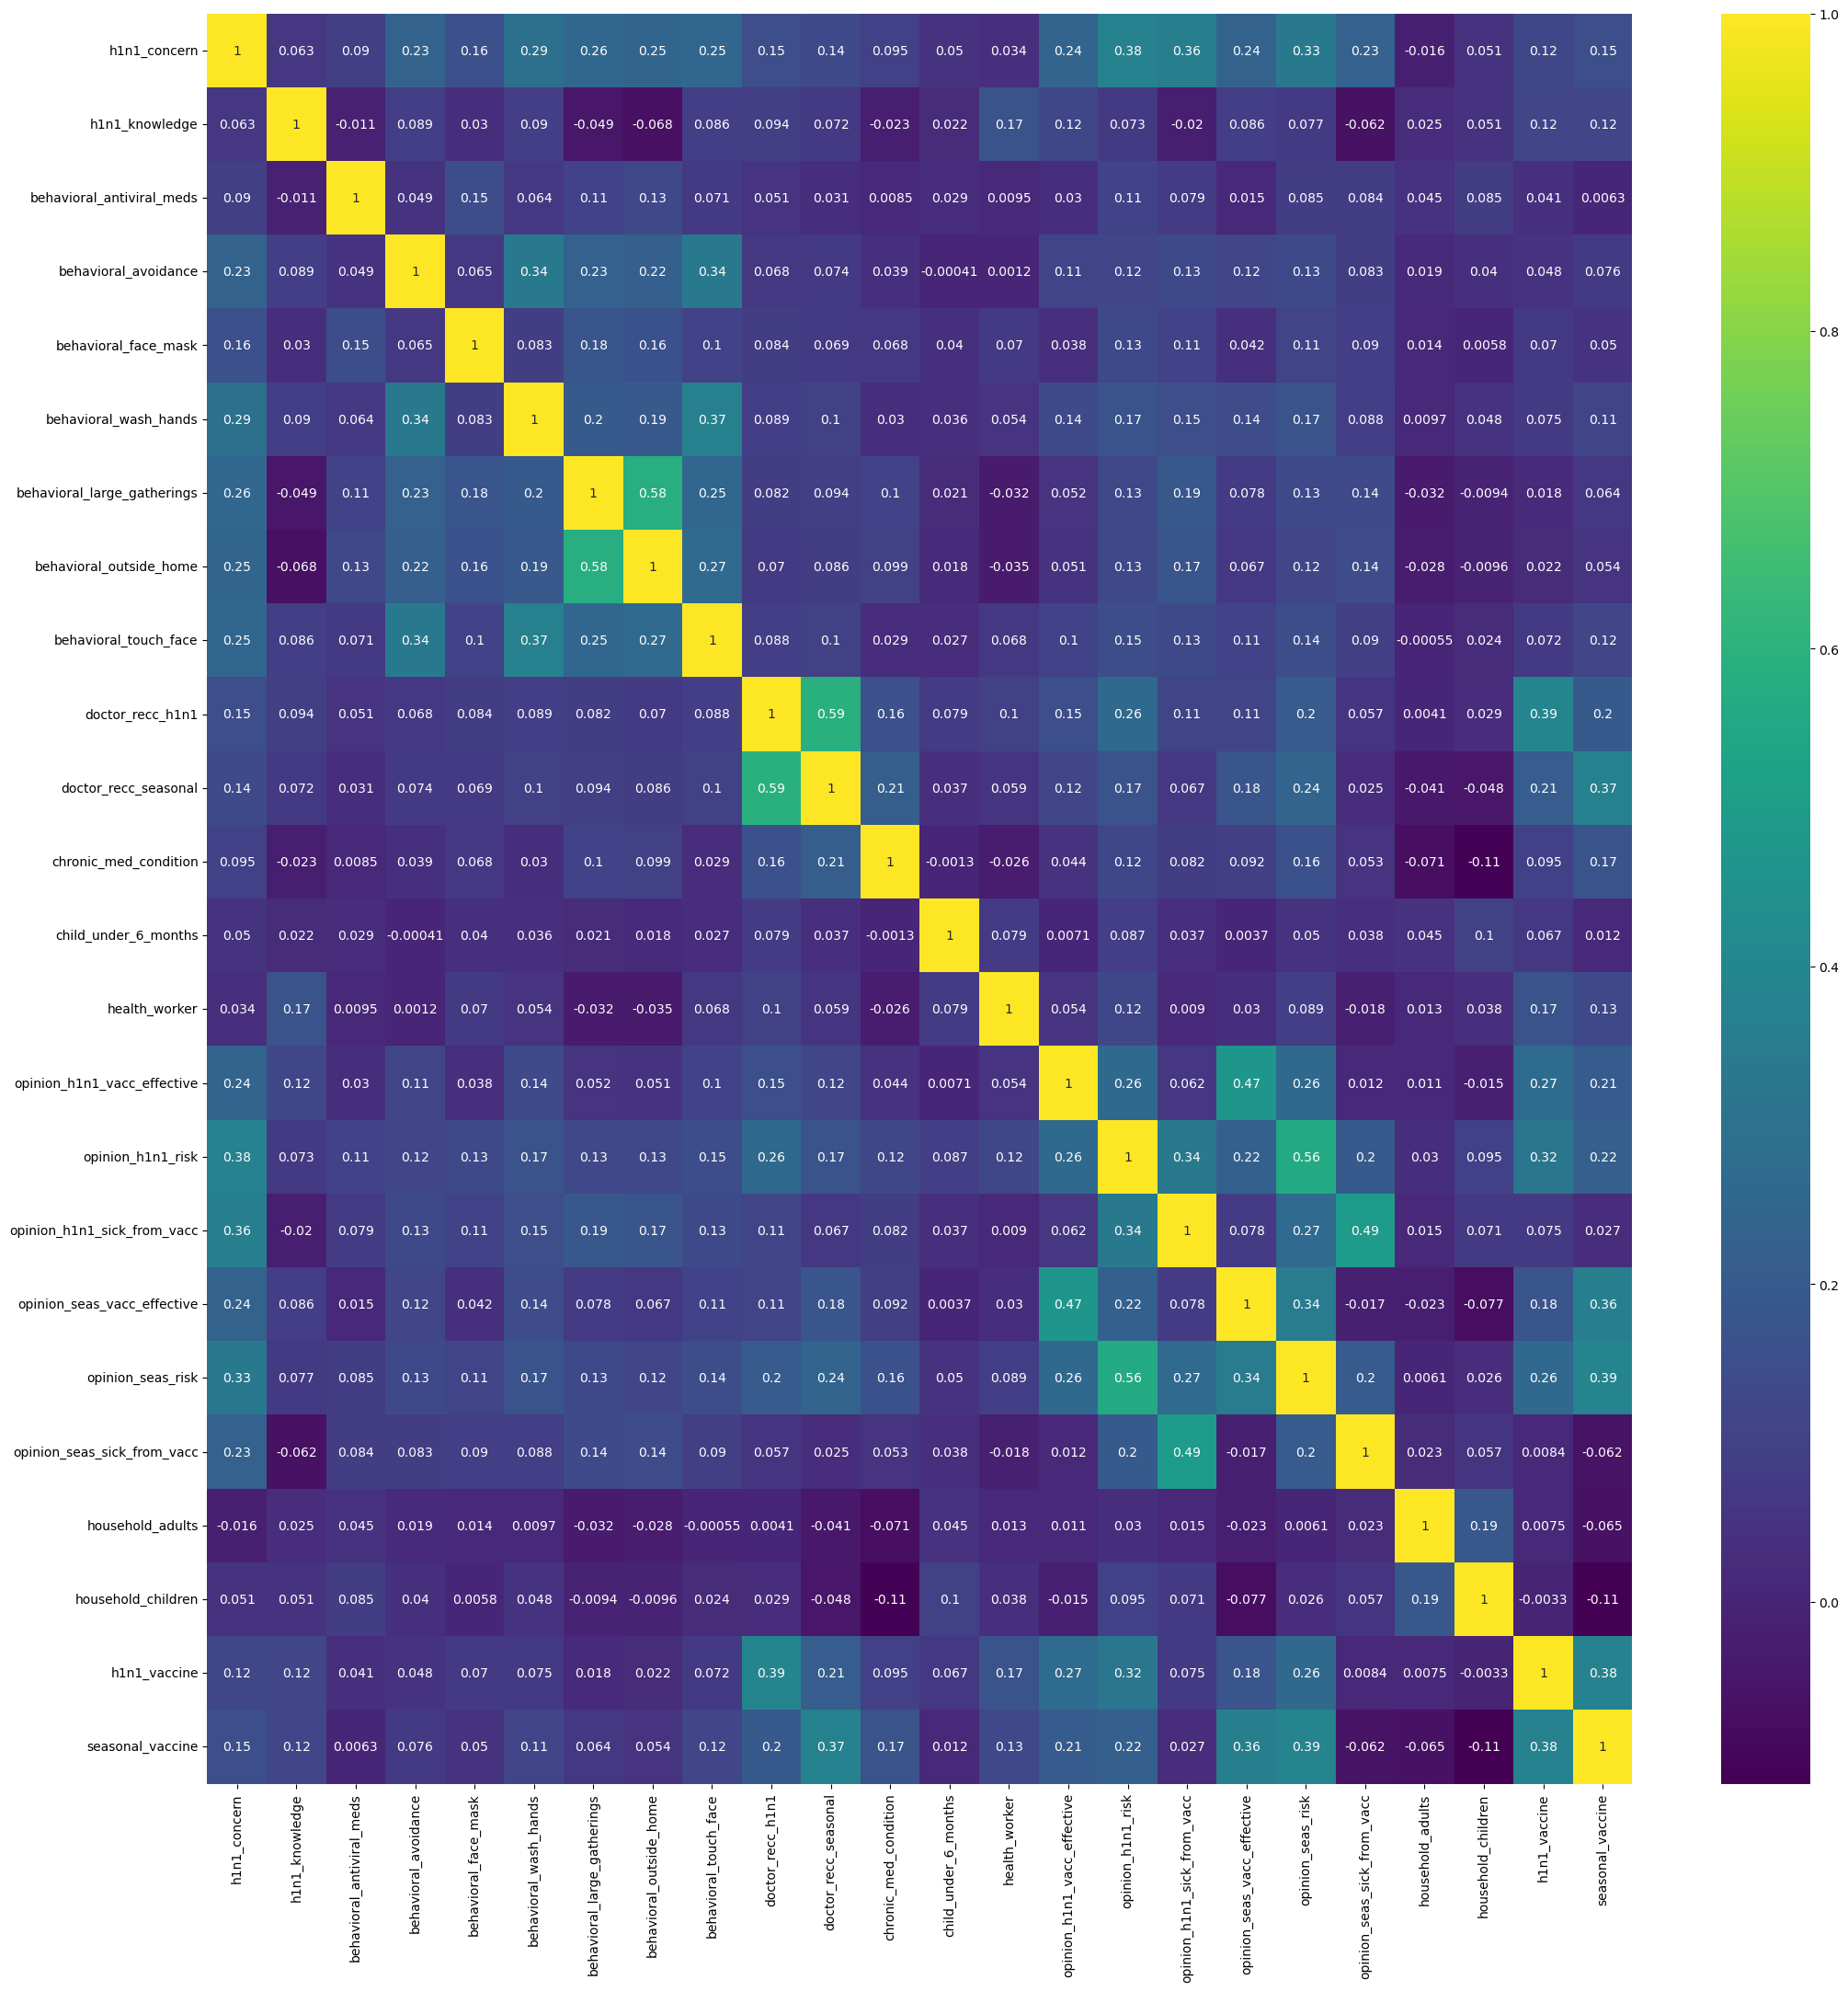

In [2357]:
#We use the combined dataframe to visualise the correlation between the features using a heatmap
corrmat = combined_df.corr()
correlation_features = corrmat.index
plt.figure(figsize=(25,25))

sns.heatmap(combined_df[correlation_features].corr(), annot=True, cmap="viridis")

Out of the behavioral ones, wearing a face mask seems to provide the highest correlation with both vaccines, behavioral_wash_hands and behavioral_touch_face seem to have a higher correlation with the seasonal_vaccine results than the h1n1 one. The other behavioral features have a correlation close to 0 with the vaccine acceptance/refusal.

The vaccines seem to have a relatively high correlation with each other. The doctor_recc_h1n1, doctor_recc_seasonal opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_seas_vacc_effective, opinion_seas_risk seem to have a noticable influence on the vaccination outcome too. 

Most of the other features seem to have an important correlation with only one of the vaccines.

<AxesSubplot: >

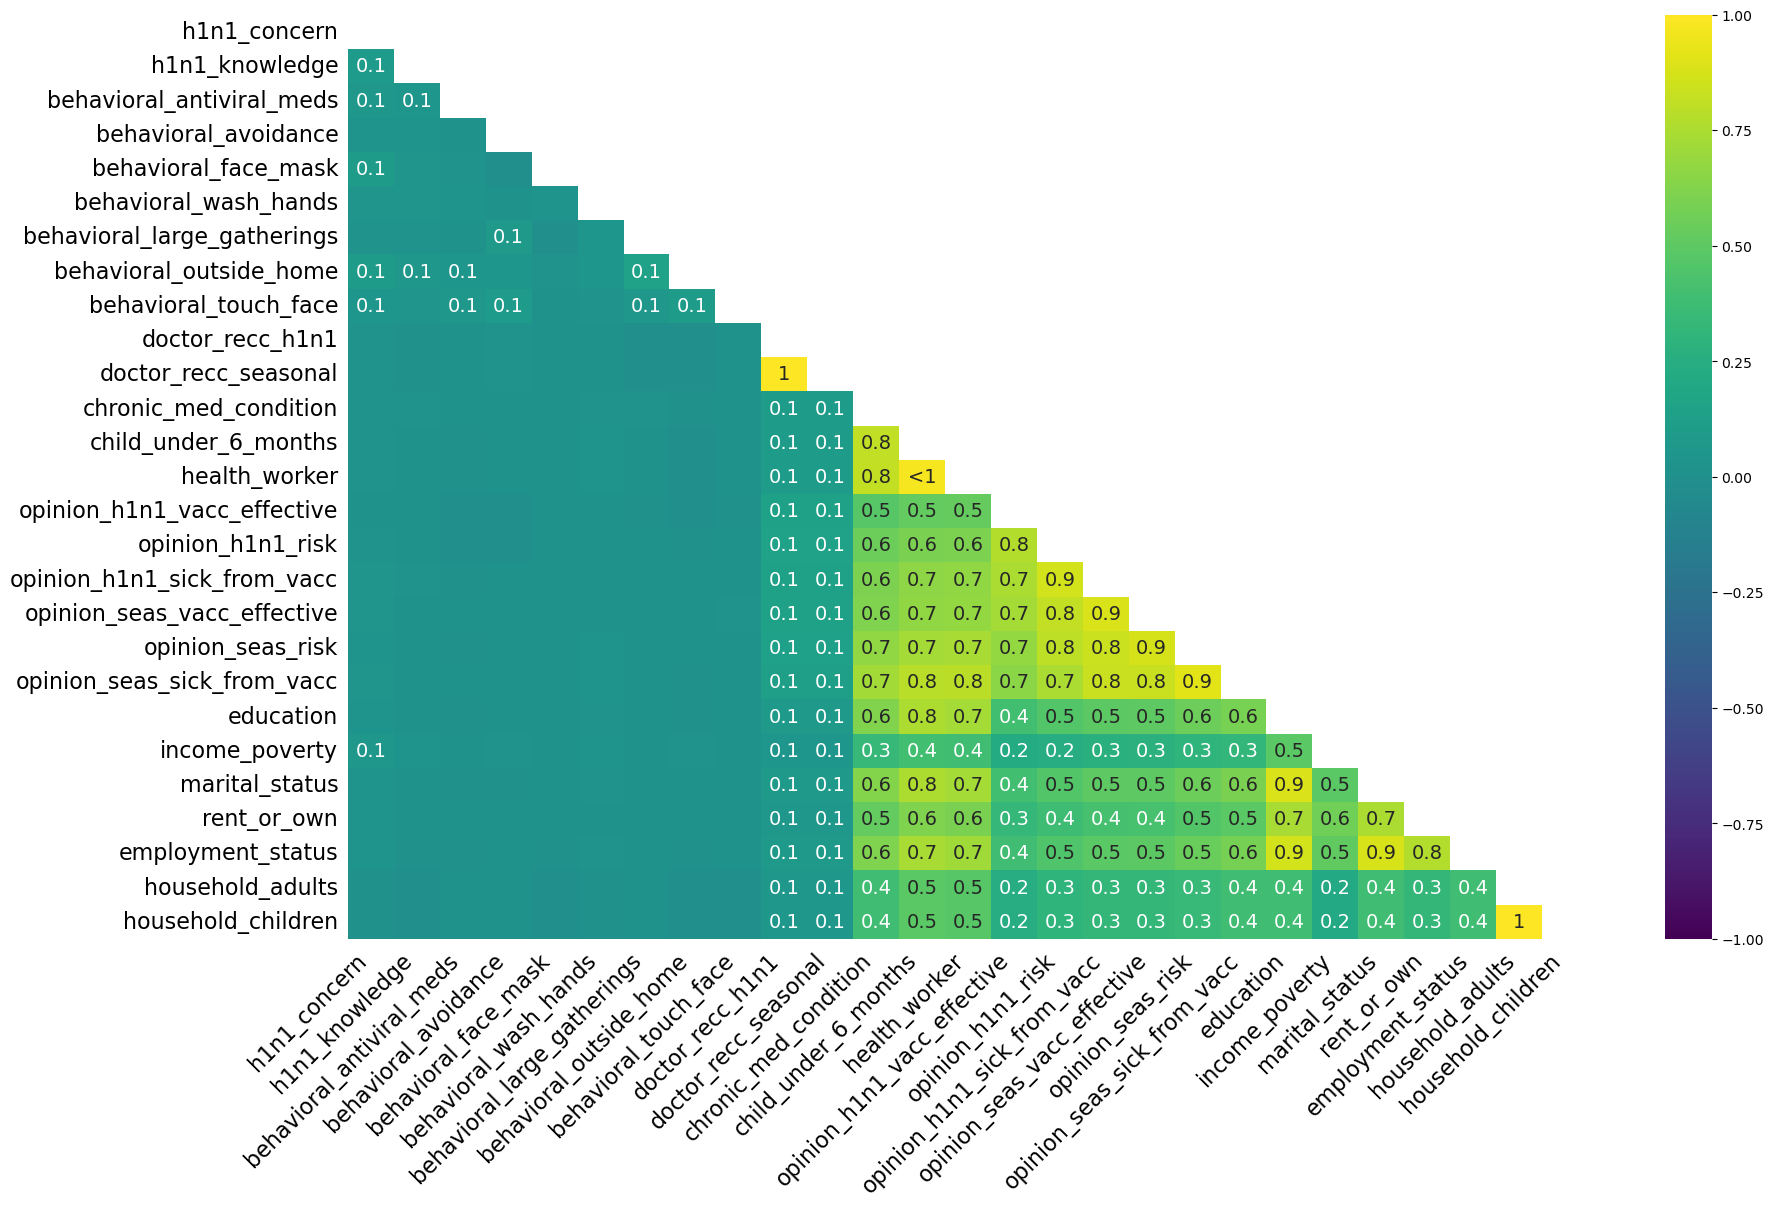

In [2269]:
# heatmap to measure how strongly the presence or absence of a variable affects the presence of another variable
mno.heatmap(combined_df, cmap='viridis')

There seems to be a strong relationship between doctors recommending the h1n1 vaccine and the seasonal vaccine, another strong relationship is between the number of household adults and household children. Their marital status and education and employment status seem to have a relatively strong relationship. 

Another discovery is that there is a strong relationship between a person's opinion on the risks of the disease and the effectiveness of the vaccine.

The behavioral features don't seem to affect the results for the other features much neither positively nor negatively.

<AxesSubplot: >

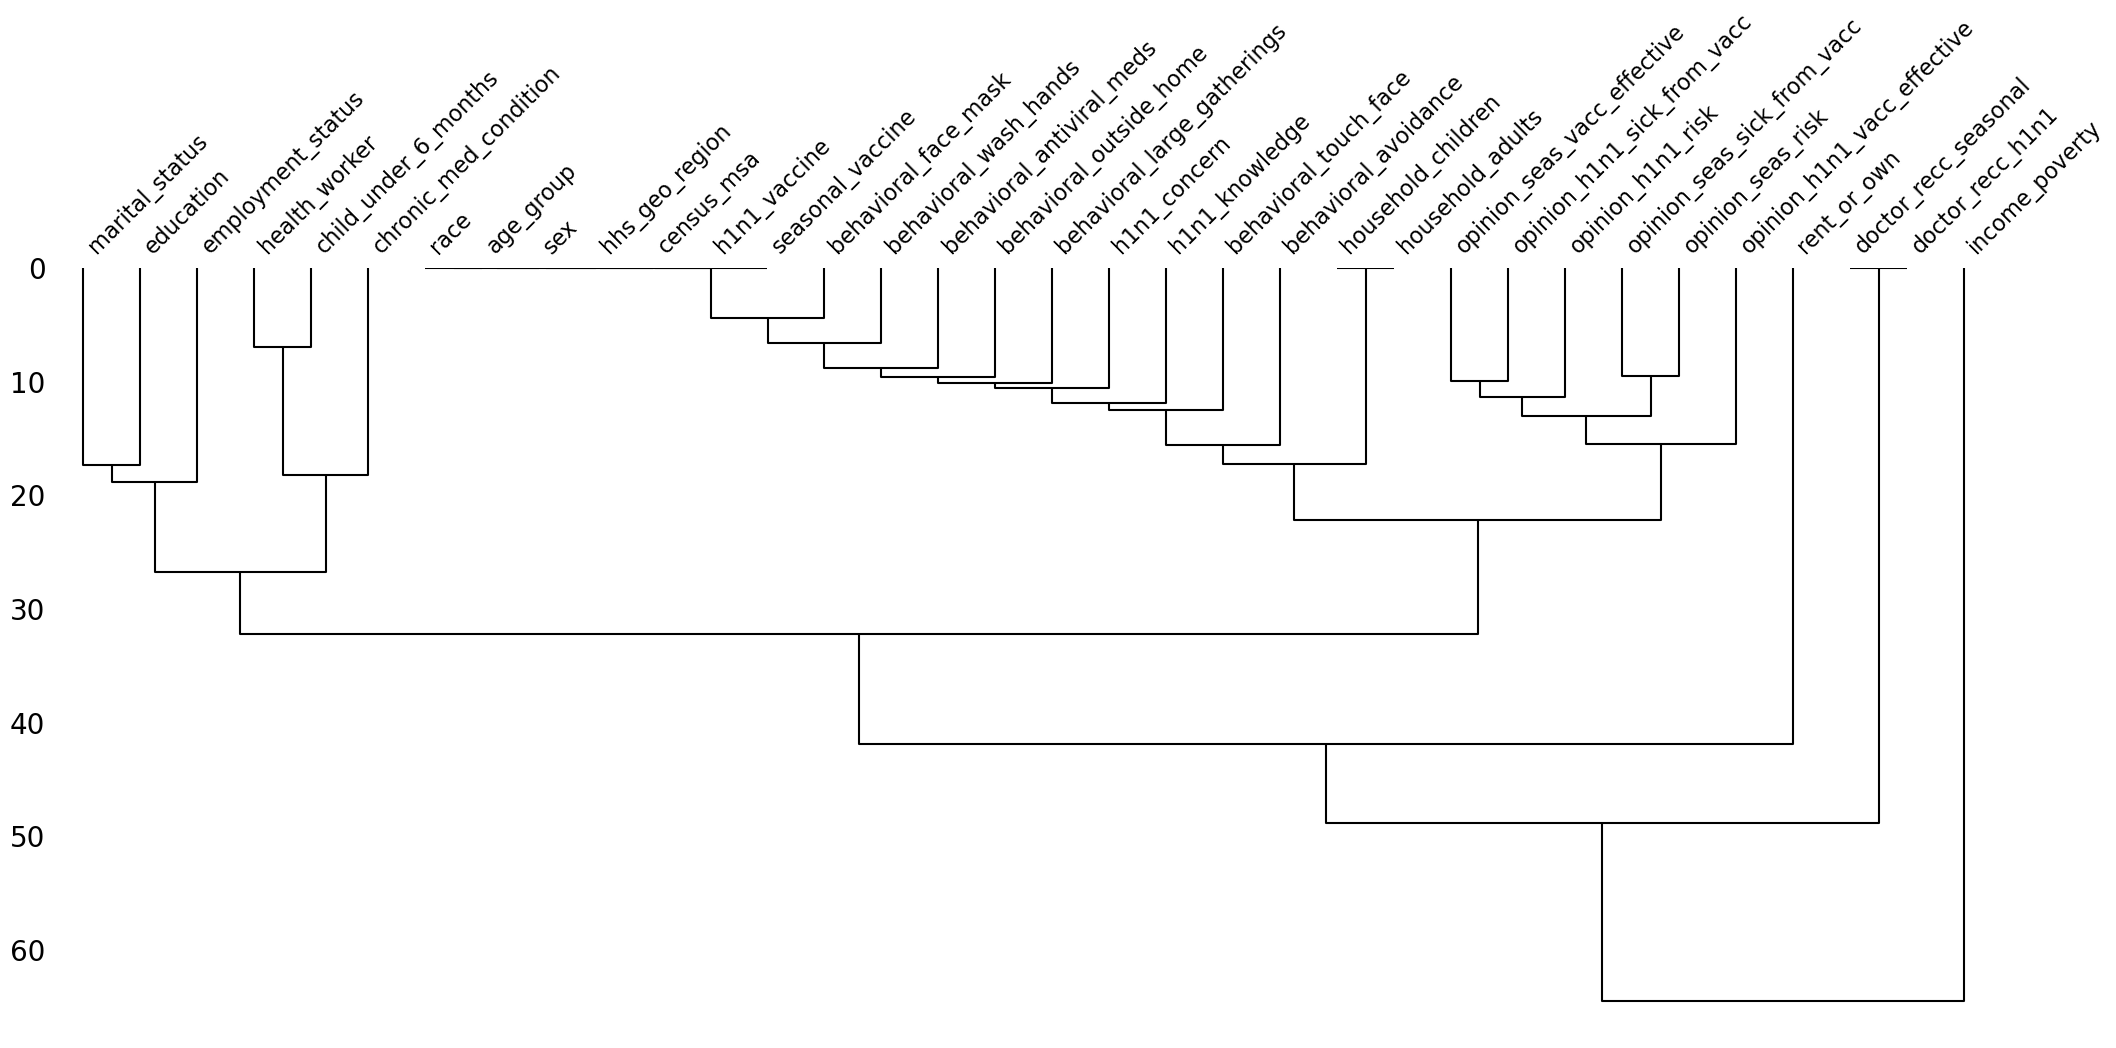

In [2166]:
#Create a dendrogram to show more in depth connections between features
mno.dendrogram(combined_df)

Here a top-down approach is used to make conclusions on the clustered variables using a dendogram. A dendrogram is a diagram that represents the hierarchical clustering of data points.

This allows for a detailed understanding of the connections between features in the dataset. Each feature will be represented as a node in the dendrogram, and the structure of the dendrogram will show the relationships and similarities between these features.

The behaviours are related with each other, similarly people's opinions on the disease and vaccines are related. Their personal choises abour family, education and employment are a different cluster. 

The flat line indicates that the data points or clusters are not forming distinct groups or subgroups based on their similarity or dissimilarity. It implies that there is no clear hierarchical structure or evident clustering pattern between the features, in this case, race, age_group, sex, region and census.

## Cross Tabulation

We will analyse which features may assist in the prediction of vaccination decision. 
We will begin by evaluating all the behavioural related variables below: 

- behavioral_antiviral_meds      
- behavioral_avoidance           
- behavioral_face_mask           
- behavioral_wash_hands          
- behavioral_large_gatherings    
- behavioral_outside_home        
- behavioral_touch_face

The data is binary.

In [2270]:
# Function to calculate a cross-tabulation between two variables and normalize the result by columns

def crosstab(x, y):

    return pd.crosstab(x, y, normalize='columns')*100

In [2168]:
crosstab(labels['h1n1_vaccine'], features['behavioral_antiviral_meds'])


behavioral_antiviral_meds,0.0,1.0
h1n1_vaccine,,
0,79.182948,71.483474
1,20.817052,28.516526


In [2169]:
crosstab(labels['seasonal_vaccine'], features['behavioral_antiviral_meds'])

behavioral_antiviral_meds,0.0,1.0
seasonal_vaccine,,
0,53.566213,52.113759
1,46.433787,47.886241


In [2170]:
crosstab(labels['h1n1_vaccine'], features['behavioral_avoidance'])

behavioral_avoidance,0.0,1.0
h1n1_vaccine,,
0,81.886948,77.511962
1,18.113052,22.488038


In [2171]:
crosstab(labels['seasonal_vaccine'], features['behavioral_avoidance'])

behavioral_avoidance,0.0,1.0
seasonal_vaccine,,
0,59.647916,51.10776
1,40.352084,48.89224


In [2172]:
crosstab(labels['h1n1_vaccine'], features['behavioral_face_mask'])

behavioral_face_mask,0.0,1.0
h1n1_vaccine,,
0,79.546827,68.169473
1,20.453173,31.830527


In [2173]:
crosstab(labels['seasonal_vaccine'], features['behavioral_face_mask'])

behavioral_face_mask,0.0,1.0
seasonal_vaccine,,
0,54.127259,44.269419
1,45.872741,55.730581


In [2174]:
crosstab(labels['h1n1_vaccine'], features['behavioral_wash_hands'])

behavioral_wash_hands,0.0,1.0
h1n1_vaccine,,
0,85.397849,77.342721
1,14.602151,22.657279


In [2175]:
crosstab(labels['seasonal_vaccine'], features['behavioral_wash_hands'])

behavioral_wash_hands,0.0,1.0
seasonal_vaccine,,
0,65.634409,50.856234
1,34.365591,49.143766


In [2176]:
crosstab(labels['h1n1_vaccine'], features['behavioral_large_gatherings'])

behavioral_large_gatherings,0.0,1.0
h1n1_vaccine,,
0,79.283079,77.762648
1,20.716921,22.237352


In [2177]:
crosstab(labels['seasonal_vaccine'], features['behavioral_large_gatherings'])

behavioral_large_gatherings,0.0,1.0
seasonal_vaccine,,
0,55.836701,49.177752
1,44.163299,50.822248


In [2178]:
crosstab(labels['h1n1_vaccine'], features['behavioral_outside_home'])

behavioral_outside_home,0.0,1.0
h1n1_vaccine,,
0,79.369757,77.485803
1,20.630243,22.514197


In [2179]:
crosstab(labels['seasonal_vaccine'], features['behavioral_outside_home'])

behavioral_outside_home,0.0,1.0
seasonal_vaccine,,
0,55.350261,49.704933
1,44.649739,50.295067


In [2180]:
crosstab(labels['seasonal_vaccine'], features['behavioral_touch_face'])

behavioral_touch_face,0.0,1.0
seasonal_vaccine,,
0,62.135696,49.308372
1,37.864304,50.691628


The cross-tabulation table shows that individuals who exhibit positive behaviors such as taking antiviral meds, avoiding close contact, wearing face masks, washing hands regularly, attending large gatherings, going outside, and refraining from touching their faces are more likely to take vaccines.

The table reveals that as the number of positive behaviors increases, the percentage of people taking vaccines also tends to increase. This suggests a positive association between adopting these behaviors and vaccine uptake. It indicates that individuals who are more proactive in practicing preventive measures and following recommended guidelines are more inclined to prioritize their health and well-being by getting vaccinated.

## Models

### Creating Evaluation Metric

In [2181]:
#Driven data function to evaluate model's performance
def plot_roc(y_true, y_score, label_name, ax, color=False):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    if color:
        ax.set_facecolor('lightblue')
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {metrics.roc_auc_score(y_true, y_score):.4f}"
    )

### Random Forest

In [2279]:
# Perform a train-test split on the features and labels datasets
# The training set will contain 70% of the data, and the testing set will contain 30% of the data
# The random_state parameter ensures reproducibility of the split
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.3, random_state=69)


In [2280]:
# Defines a ClassifierChain that applies multiple classifiers in a chain
# The chain includes feature selection, scaling, and a Random Forest classifier
chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif),
#StandardScaler(),
MinMaxScaler(),
#RobustScaler(),
RandomForestClassifier()))

# Create a pipeline that combines preprocessing and the classifier chain
forest_pipe = make_pipeline(default_preprocessor, chain)

forest_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('boolean_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',...
                                                  ['race', 'sex',
                                                   'marital_status',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'rent_or_own'])])),
                ('classifierchain',
                 ClassifierChain(base_estimator=Pipeline(steps=[('selectpercentile',
                                                                 SelectPercentile(score_func=<function mutual_info_classif at 0x0000017C26053010>)),
                                                                ('minmaxscaler',
                                                                 MinMaxScaler()),
                                                                ('randomforestclassifier',
                                                                 RandomForestClassifier())])))])

In [2281]:
# Find best parameters for the model

params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 20, 50],
    'classifierchain__base_estimator__randomforestclassifier__n_estimators': list(range(100, 600, 100)),
    'classifierchain__base_estimator__randomforestclassifier__criterion': ['gini', 'entropy'],
    'classifierchain__base_estimator__randomforestclassifier__max_depth': list(range(5, 16)),
    'classifierchain__base_estimator__randomforestclassifier__bootstrap': [True, False],
    'classifierchain__order': [[0, 1], [1, 0]]
}

#As we have already searched for the best parameters, we define them bellow
best_params = {'classifierchain__base_estimator__selectpercentile__percentile': [50],
    'classifierchain__base_estimator__randomforestclassifier__n_estimators': [200],
    'classifierchain__base_estimator__randomforestclassifier__criterion': ['entropy'],
    'classifierchain__base_estimator__randomforestclassifier__max_depth': [11],
    'classifierchain__base_estimator__randomforestclassifier__bootstrap': [True],
    'classifierchain__order': [[0, 1]]
}


#forest_grid = RandomizedSearchCV(forest_pipe, params, scoring='roc_auc', n_iter=150, verbose=1, n_jobs=4)


# Perform randomized search for hyperparameter tuning on the forest_pipe pipeline
# The search is based on the defined parameter grid (best_params)
# The scoring metric used is 'roc_auc' 
# The n_iter parameter specifies the number of parameter settings that are sampled from the parameter grid
# The verbose parameter controls the verbosity of the output during the search
# The n_jobs parameter specifies the number of CPU cores to use (-1 means using all available cores)

forest_grid = RandomizedSearchCV(forest_pipe, best_params, scoring='roc_auc', n_iter=1, verbose=1, n_jobs=-1)

# Fit the forest_grid randomized search object to the training data
forest_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('boolean_imputer',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_to...
                                        'classifierchain__base_estimator__randomforestclassifier__criterion': ['entropy'],
                                        'classifierchain__base_estimator__randomforestclassifier__max_depth': [11],
                                        'classifierchain__base_estimator__randomforestclassifier__n_estimators': [200],
                                        'classifierchain__base_estimator__selectpercentile__percentile': [50],
                                        'classifierchain__order': [[0, 1]]},
                   scoring='roc_auc', verbose=1)

In [2275]:
# Show the best parameters for the model
display(forest_grid.best_params_)

#classifierchain__order': [0, 1],
# 'classifierchain__base_estimator__selectpercentile__percentile': 50,
# 'classifierchain__base_estimator__randomforestclassifier__n_estimators': 200,
# 'classifierchain__base_estimator__randomforestclassifier__max_depth': 11,
# 'classifierchain__base_estimator__randomforestclassifier__criterion': 'entropy',
# 'classifierchain__base_estimator__randomforestclassifier__bootstrap': True}

{'classifierchain__order': [0, 1],
 'classifierchain__base_estimator__selectpercentile__percentile': 50,
 'classifierchain__base_estimator__randomforestclassifier__n_estimators': 200,
 'classifierchain__base_estimator__randomforestclassifier__max_depth': 11,
 'classifierchain__base_estimator__randomforestclassifier__criterion': 'entropy',
 'classifierchain__base_estimator__randomforestclassifier__bootstrap': True}

In [2282]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(forest_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(forest_grid.score(X_test, Y_test)))

Best model in-sample score: 0.9018
Best model out-of-sample score: 0.8432


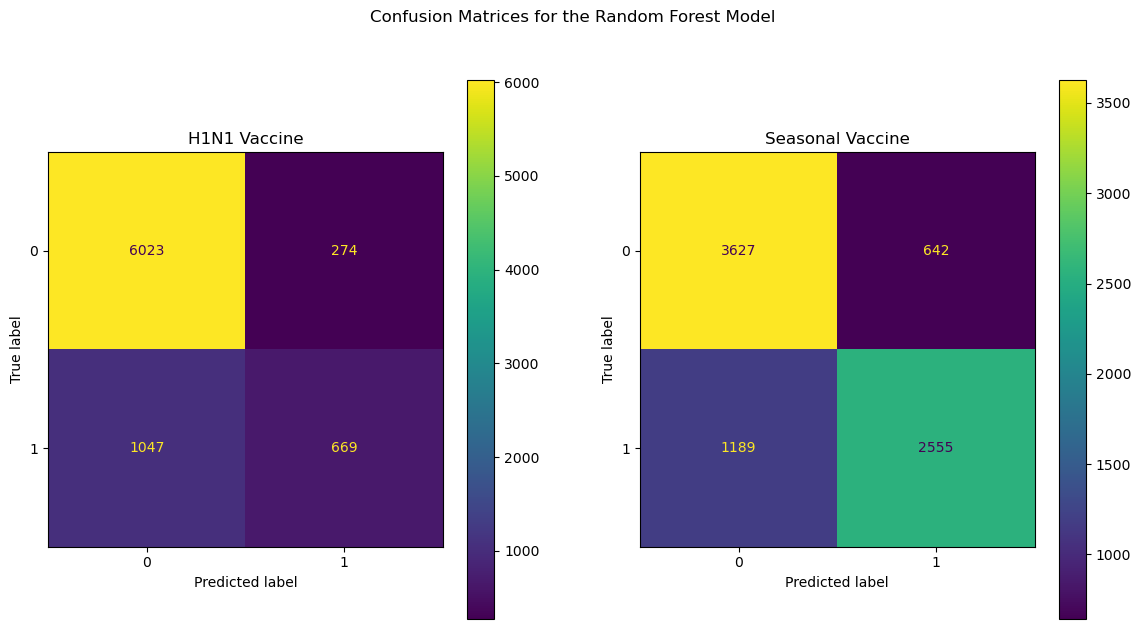

In [2283]:
# Confusion Matrix for Random Forest 
predictions = forest_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for the Random Forest Model')
plt.show()

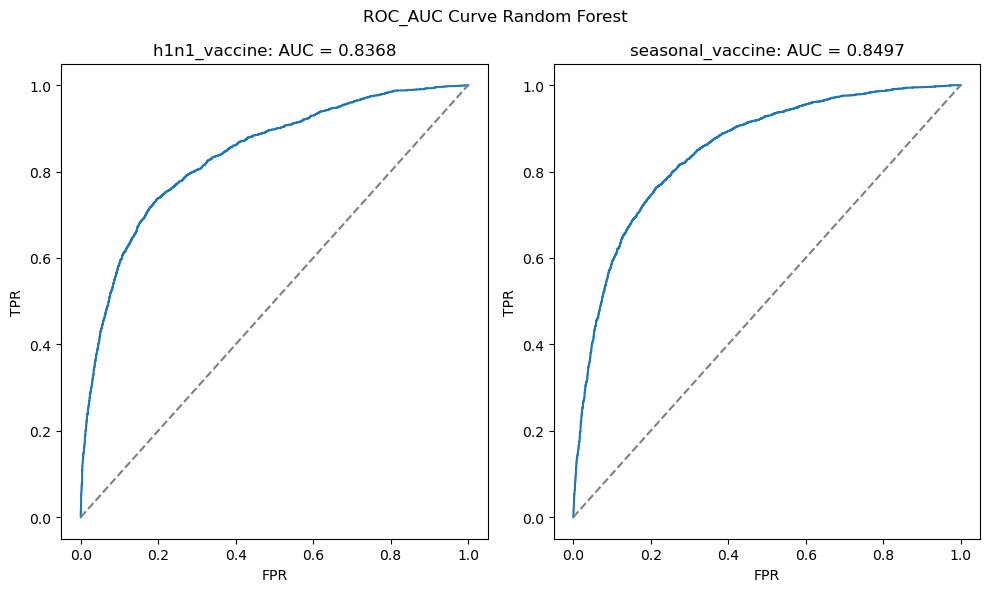

In [2284]:
#ROC_AUC Curve for Random Forest
y_preds = forest_grid.predict_proba(X_test)
y_preds_both = pd.DataFrame({"h1n1_vaccine":y_preds[:, 0], "seasonal_vaccine":y_preds[:, 1]}, index=Y_test.index)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle(f"ROC_AUC Curve Random Forest")

plot_roc(Y_test['h1n1_vaccine'], y_preds_both['h1n1_vaccine'], 'h1n1_vaccine',ax=ax[0])
plot_roc(Y_test['seasonal_vaccine'], y_preds_both['seasonal_vaccine'], 'seasonal_vaccine',ax=ax[1])
fig.tight_layout()

### XGBoost

In [2286]:
# Define a ClassifierChain that applies multiple classifiers in a chain
# The chain includes feature selection, scaling, and an XGBoost classifier
chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif),
#StandardScaler(),
MinMaxScaler(),
#RobustScaler(),
XGBClassifier(use_label_encoder=False, verbosity=0, n_jobs=1)))

# Create a pipeline that combines preprocessing and the classifier chain
xgb_pipe = make_pipeline(default_preprocessor, chain)

xgb_pipe

c:\Users\danie\anaconda3\envs\COMP4030\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('boolean_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',...
                                                                               gpu_id=None,
                                                                               grow_policy=None,
                                                                               importance_type=None,
                                                                               interaction_constraints=None,
                                                                               learning_rate=None,
                                                                               max_bin=None,
                                                                               max_cat_threshold=None,
                                                                               max_cat_to_onehot=None,
                                                                               max_delta_step=None,
                                                                               max_depth=None,
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               n_estimators=100,
                                                                               n_jobs=1,
                                                                               num_parallel_tree=None,
                                                                               predictor=None,
                                                                               random_state=None, ...))])))])

In [2287]:

params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 50, 90],
    'classifierchain__base_estimator__xgbclassifier__n_estimators': [100, 200, 500],
    'classifierchain__base_estimator__xgbclassifier__max_depth': list(range(1, 6)),
    'classifierchain__base_estimator__xgbclassifier__learning_rate': [0.1, 0.2],
    'classifierchain__base_estimator__xgbclassifier__reg_lambda': [0.1, 0.2, 0.3],
    'classifierchain__order': [[0, 1], [1, 0]]
}


best_xgb_params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [90],
    'classifierchain__base_estimator__xgbclassifier__n_estimators': [200],
    'classifierchain__base_estimator__xgbclassifier__max_depth': [3],
    'classifierchain__base_estimator__xgbclassifier__learning_rate': [0.1],
    'classifierchain__base_estimator__xgbclassifier__reg_lambda': [0.1],
    'classifierchain__order': [[0, 1]]
}


#xgb_grid = RandomizedSearchCV(xgb_pipe, params, scoring='roc_auc', n_iter=280, verbose=1, n_jobs=-1)

# Perform randomized search for hyperparameter tuning on the xgb_pipe pipeline
# The search is based on the defined parameter grid (best_xgb_params)
# The scoring metric used is 'roc_auc' 
# The n_iter parameter specifies the number of parameter settings that are sampled from the parameter grid
# The verbose parameter controls the verbosity of the output during the search
# The n_jobs parameter specifies the number of CPU cores to use (-1 means using all available cores)
xgb_grid = RandomizedSearchCV(xgb_pipe, best_xgb_params, scoring='roc_auc', n_iter=1, verbose=1, n_jobs=-1)


# Fit the xgb_grid randomized search object to the training data
xgb_grid.fit(X_train, Y_train.astype(int))

c:\Users\danie\anaconda3\envs\COMP4030\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\danie\anaconda3\envs\COMP4030\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('boolean_imputer',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_to...
                   param_distributions={'classifierchain__base_estimator__selectpercentile__percentile': [90],
                                        'classifierchain__base_estimator__xgbclassifier__learning_rate': [0.1],
                                        'classifierchain__base_estimator__xgbclassifier__max_depth': [3],
                                        'classifierchain__base_estimator__xgbclassifier__n_estimators': [200],
                                        'classifierchain__base_estimator__xgbclassifier__reg_lambda': [0.1],
                                        'classifierchain__order': [[0, 1]]},
                   scoring='roc_auc', verbose=1)

In [2288]:
# Best parameters for the model
display(xgb_grid.best_params_)

#{'classifierchain__order': [0, 1],
# 'classifierchain__base_estimator__xgbclassifier__reg_lambda': 0.1,
# 'classifierchain__base_estimator__xgbclassifier__n_estimators': 100,
# 'classifierchain__base_estimator__xgbclassifier__max_depth': 4,
# 'classifierchain__base_estimator__xgbclassifier__learning_rate': 0.1,
# 'classifierchain__base_estimator__selectpercentile__percentile': 90}

{'classifierchain__order': [0, 1],
 'classifierchain__base_estimator__xgbclassifier__reg_lambda': 0.1,
 'classifierchain__base_estimator__xgbclassifier__n_estimators': 200,
 'classifierchain__base_estimator__xgbclassifier__max_depth': 3,
 'classifierchain__base_estimator__xgbclassifier__learning_rate': 0.1,
 'classifierchain__base_estimator__selectpercentile__percentile': 90}

In [2289]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(xgb_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(xgb_grid.score(X_test, Y_test)))

Best model in-sample score: 0.8610
Best model out-of-sample score: 0.8499


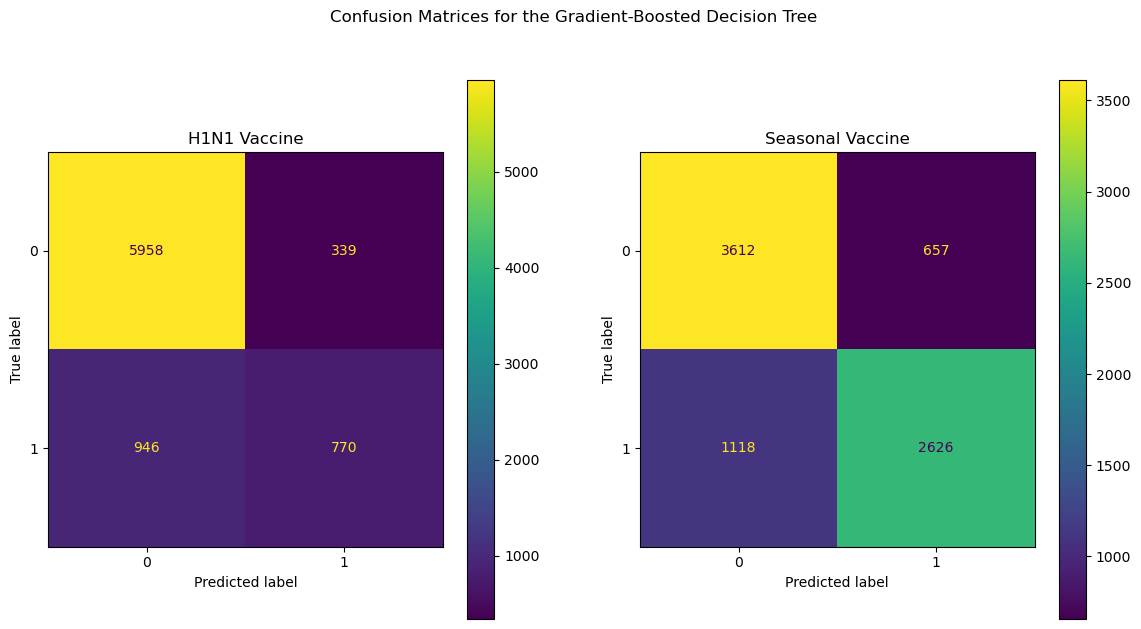

In [2290]:
# Display confusion matrices for the XGBoost Model

from sklearn.metrics import ConfusionMatrixDisplay

predictions = xgb_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for the Gradient-Boosted Decision Tree')
plt.show()

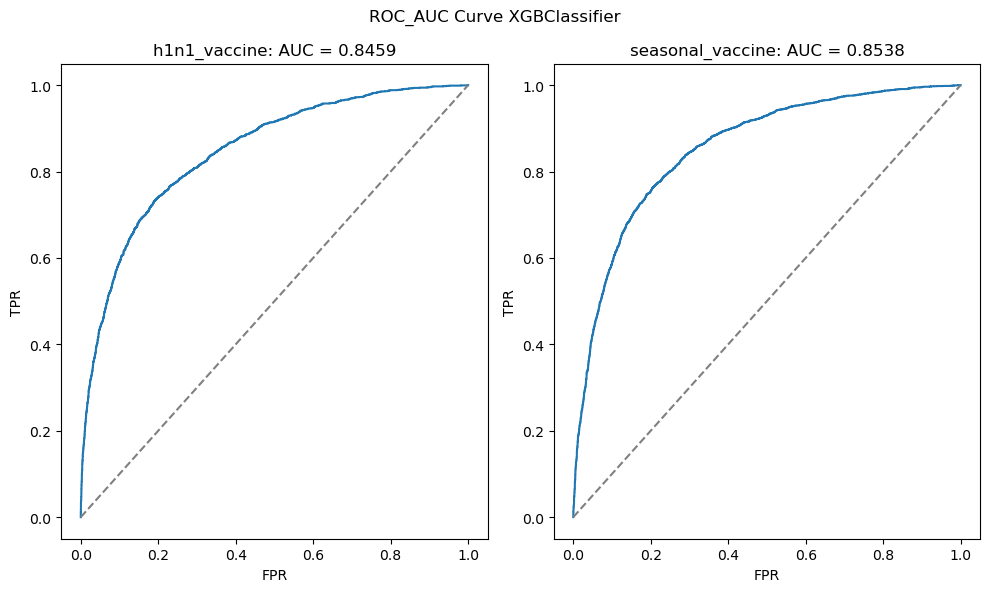

In [2292]:
# Display the ROC_AUC curve for the XGBoost model
y_preds = xgb_grid.predict_proba(X_test)
y_preds_both = pd.DataFrame({"h1n1_vaccine":y_preds[:, 0], "seasonal_vaccine":y_preds[:, 1]}, index=Y_test.index)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle(f"ROC_AUC Curve XGBClassifier")

plot_roc(Y_test['h1n1_vaccine'], y_preds_both['h1n1_vaccine'], 'h1n1_vaccine',ax=ax[0])
plot_roc(Y_test['seasonal_vaccine'], y_preds_both['seasonal_vaccine'], 'seasonal_vaccine',ax=ax[1])
fig.tight_layout()

### Multilabel K-Nearest Neighbour

In [2293]:
# Define a ClassifierChain that applies multiple classifiers in a chain
# The chain includes feature selection, scaling, and a KNN classifier
chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif),
#StandardScaler(), 
MinMaxScaler(),
#RobustScaler(),
KNeighborsClassifier()))

# Create a pipeline that combines preprocessing and the classifier chain
knn_pipe = make_pipeline(default_preprocessor, chain)

In [2294]:
# Finding the best parameters for the model
"""
params = {
    'classifierchain__base_estimator__kneighborsclassifier__n_neighbors': list(range(60, 160, 10)),
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 20, 50],
    'classifierchain__base_estimator__kneighborsclassifier__weights': ['uniform', 'distance'],
    'classifierchain__base_estimator__kneighborsclassifier__p': [1, 2],
    'classifierchain__order': [[0,1], [1,0]]
}

"""
best_knn_params = {'classifierchain__order': [[0, 1]],
 'classifierchain__base_estimator__selectpercentile__percentile': [20],
 'classifierchain__base_estimator__kneighborsclassifier__weights': ['uniform'],
 'classifierchain__base_estimator__kneighborsclassifier__p': [1],
 'classifierchain__base_estimator__kneighborsclassifier__n_neighbors': [150]}


#KNN_Grid = RandomizedSearchCV(KNN_pipe, params, scoring='roc_auc', n_iter = 160, verbose=1, n_jobs=-1)



# Perform randomized search for hyperparameter tuning on the knn_pipe pipeline
# The search is based on the defined parameter grid (best_knn_params)
# The scoring metric used is 'roc_auc' 
# The n_iter parameter specifies the number of parameter settings that are sampled from the parameter grid
# The verbose parameter controls the verbosity of the output during the search
# The n_jobs parameter specifies the number of CPU cores to use (-1 means using all available cores)
knn_grid = RandomizedSearchCV(knn_pipe, best_knn_params, scoring='roc_auc', n_iter = 1, verbose=1, n_jobs=-1)

# Fit the knn_grid randomized search object to the training data
knn_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('boolean_imputer',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_to...
                   param_distributions={'classifierchain__base_estimator__kneighborsclassifier__n_neighbors': [150],
                                        'classifierchain__base_estimator__kneighborsclassifier__p': [1],
                                        'classifierchain__base_estimator__kneighborsclassifier__weights': ['uniform'],
                                        'classifierchain__base_estimator__selectpercentile__percentile': [20],
                                        'classifierchain__order': [[0, 1]]},
                   scoring='roc_auc', verbose=1)

In [2197]:
# Best parameters for the model
#display(knn_Grid.best_params_)
""" 
{'classifierchain__order': [0, 1],
 'classifierchain__base_estimator__selectpercentile__percentile': 20,
 'classifierchain__base_estimator__kneighborsclassifier__weights': 'uniform',
 'classifierchain__base_estimator__kneighborsclassifier__p': 1,
 'classifierchain__base_estimator__kneighborsclassifier__n_neighbors': 150}
"""

" \n{'classifierchain__order': [0, 1],\n 'classifierchain__base_estimator__selectpercentile__percentile': 20,\n 'classifierchain__base_estimator__kneighborsclassifier__weights': 'uniform',\n 'classifierchain__base_estimator__kneighborsclassifier__p': 1,\n 'classifierchain__base_estimator__kneighborsclassifier__n_neighbors': 150}\n"

In [2198]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(knn_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(knn_grid.score(X_test, Y_test)))

Best model in-sample score: 0.8327
Best model out-of-sample score: 0.8263


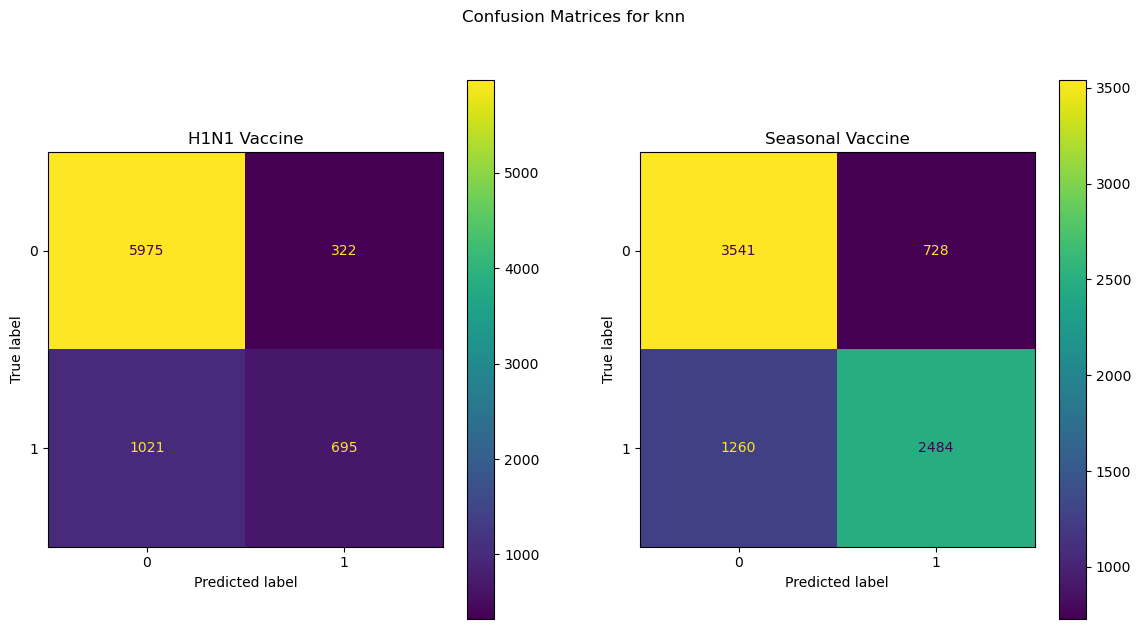

In [2295]:
# Display confusion matrices for the KNN Model

from sklearn.metrics import ConfusionMatrixDisplay

predictions = knn_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for KNN')
plt.show()

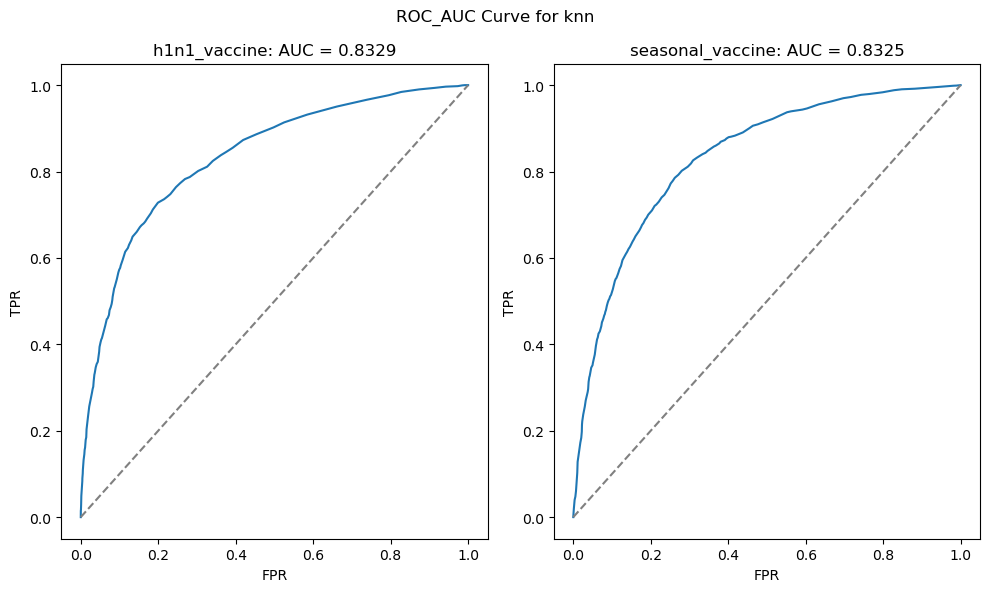

In [2296]:
#Display ROC_AUC Curve for KNN
y_preds = knn_grid.predict_proba(X_test)
y_preds_both = pd.DataFrame({"h1n1_vaccine":y_preds[:, 0], "seasonal_vaccine":y_preds[:, 1]}, index=Y_test.index)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle(f"ROC_AUC Curve for knn")

plot_roc(Y_test['h1n1_vaccine'], y_preds_both['h1n1_vaccine'], 'h1n1_vaccine',ax=ax[0])
plot_roc(Y_test['seasonal_vaccine'], y_preds_both['seasonal_vaccine'], 'seasonal_vaccine',ax=ax[1])
fig.tight_layout()

### Naive Bayes

In [2299]:
# Define a ClassifierChain that applies multiple classifiers in a chain
# The chain includes feature selection, scaling, and a Gaussian Naive Bayes classifier
chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif),
#StandardScaler(),
MinMaxScaler(),
#RobustScaler(),
GaussianNB()))

# Create a pipeline that combines preprocessing and the classifier chain
naive_bayes_pipe = make_pipeline(default_preprocessor, chain)

# Fit the naive_bayes_pipe pipeline to the training data
naive_bayes_pipe.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('boolean_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',...
                                                                                 sparse_output=False))]),
                                                  ['race', 'sex',
                                                   'marital_status',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'rent_or_own'])])),
                ('classifierchain',
                 ClassifierChain(base_estimator=Pipeline(steps=[('selectpercentile',
                                                                 SelectPercentile(score_func=<function mutual_info_classif at 0x0000017C26053010>)),
                                                                ('minmaxscaler',
                                                                 MinMaxScaler()),
                                                                ('gaussiannb',
                                                                 GaussianNB())])))])

In [2300]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(naive_bayes_pipe.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(naive_bayes_pipe.score(X_test, Y_test)))

Best model in-sample score: 0.6300
Best model out-of-sample score: 0.6356


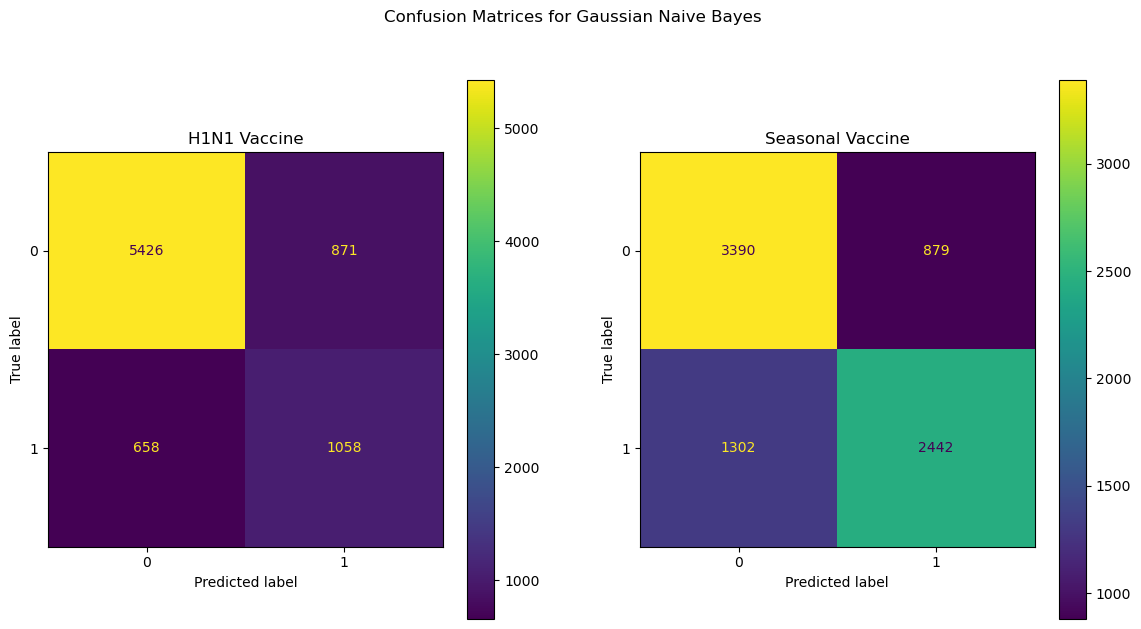

In [2301]:
# Display confusion matrices for the Naive Bayes Model
from sklearn.metrics import ConfusionMatrixDisplay

predictions = naive_bayes_pipe.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for Gaussian Naive Bayes')
plt.show()

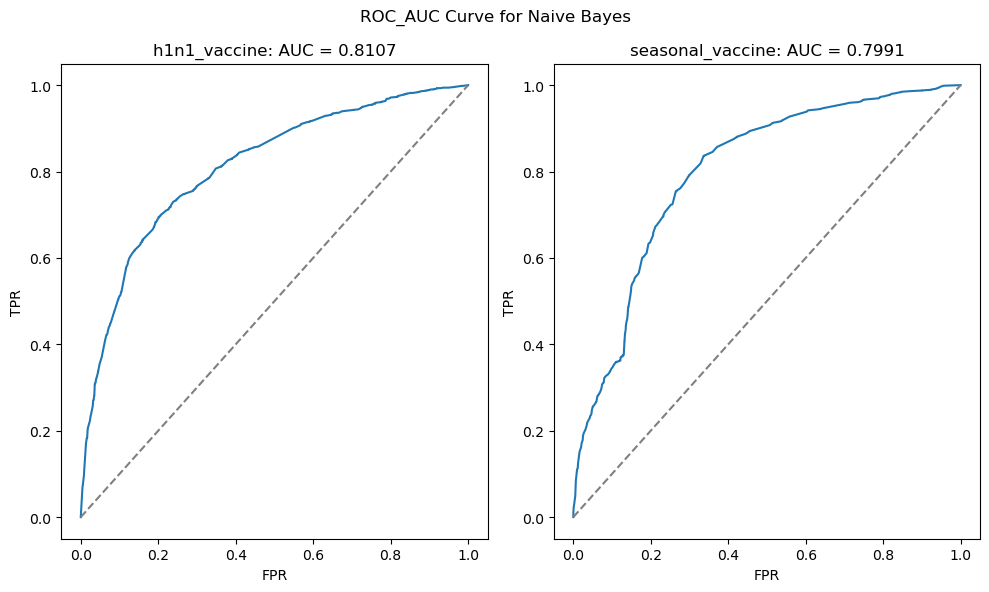

In [2302]:
#Display the ROC_AUC Curve for the Naive Bayes Model
y_preds = naive_bayes_pipe.predict_proba(X_test)
y_preds_both = pd.DataFrame({"h1n1_vaccine":y_preds[:, 0], "seasonal_vaccine":y_preds[:, 1]}, index=Y_test.index)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle(f"ROC_AUC Curve for Naive Bayes")

plot_roc(Y_test['h1n1_vaccine'], y_preds_both['h1n1_vaccine'], 'h1n1_vaccine',ax=ax[0])
plot_roc(Y_test['seasonal_vaccine'], y_preds_both['seasonal_vaccine'], 'seasonal_vaccine',ax=ax[1])
fig.tight_layout()

### CatBoost

In [2303]:
# Define a ClassifierChain that applies multiple classifiers in a chain
# The chain includes feature selection, scaling, and a CatBoost classifier
chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif),
#StandardScaler(),
MinMaxScaler(),
#RobustScaler(),
CatBoostClassifier()))

# Create a pipeline that combines preprocessing and the classifier chain
catboost_pipe = make_pipeline(default_preprocessor, chain)

#Finding the best parameters for CatBoost

cat_params = {
        'classifierchain__base_estimator__catboostclassifier__iterations': [100,200,300,500,1000,1200,1500],
        'classifierchain__base_estimator__catboostclassifier__learning_rate': (0.001, 0.3),
        'classifierchain__base_estimator__catboostclassifier__random_strength': (1,10),
        'classifierchain__base_estimator__catboostclassifier__bagging_temperature': (0,10),
        'classifierchain__base_estimator__catboostclassifier__max_bin': [4,5,6,8,10,20,30],
        'classifierchain__base_estimator__catboostclassifier__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
        'classifierchain__base_estimator__catboostclassifier__min_data_in_leaf': (1,10),
        'classifierchain__base_estimator__catboostclassifier__od_type' : ["Iter"],
        'classifierchain__base_estimator__catboostclassifier__od_wait' : [100],
        'classifierchain__base_estimator__catboostclassifier__max_depth': (2,10),
        'classifierchain__base_estimator__catboostclassifier__l2_leaf_reg': (1e-8, 100),
        'classifierchain__base_estimator__catboostclassifier__one_hot_max_size': [5,10,12,100,500,1024],
        'classifierchain__base_estimator__catboostclassifier__custom_metric': ['AUC'],
        'classifierchain__base_estimator__catboostclassifier__loss_function': ["Logloss"],
        'classifierchain__base_estimator__catboostclassifier__auto_class_weights': ['Balanced', 'SqrtBalanced']
    }


best_cat_params = {'classifierchain__base_estimator__catboostclassifier__random_strength': [4],
 'classifierchain__base_estimator__catboostclassifier__one_hot_max_size': [10],
 'classifierchain__base_estimator__catboostclassifier__od_wait': [100],
 'classifierchain__base_estimator__catboostclassifier__od_type': ['Iter'],
 'classifierchain__base_estimator__catboostclassifier__min_data_in_leaf': [7],
 'classifierchain__base_estimator__catboostclassifier__max_depth': [6],
 'classifierchain__base_estimator__catboostclassifier__max_bin': [5],
 'classifierchain__base_estimator__catboostclassifier__loss_function': ['Logloss'],
 'classifierchain__base_estimator__catboostclassifier__learning_rate': [0.058],
 'classifierchain__base_estimator__catboostclassifier__l2_leaf_reg': [12],
 'classifierchain__base_estimator__catboostclassifier__iterations': [500],
 'classifierchain__base_estimator__catboostclassifier__grow_policy': ['Lossguide'],
 'classifierchain__base_estimator__catboostclassifier__custom_metric': ['AUC'],
 'classifierchain__base_estimator__catboostclassifier__bagging_temperature': [8],
 'classifierchain__base_estimator__catboostclassifier__auto_class_weights': ['SqrtBalanced']}

#catboost_grid = RandomizedSearchCV(catboost_pipe, cat_params, scoring='roc_auc', n_jobs = 260, verbose=False, n_jobs=-1)

# Create a randomized search object for hyperparameter tuning
catboost_grid = RandomizedSearchCV(catboost_pipe, best_cat_params, scoring='roc_auc', n_iter = 1, verbose=False, n_jobs=-1)

catboost_grid.fit(X_train, Y_train)

0:	learn: 0.6687012	total: 242ms	remaining: 2m
1:	learn: 0.6491527	total: 457ms	remaining: 1m 53s
2:	learn: 0.6299782	total: 675ms	remaining: 1m 51s
3:	learn: 0.6127677	total: 884ms	remaining: 1m 49s
4:	learn: 0.6020551	total: 1.07s	remaining: 1m 45s
5:	learn: 0.5887217	total: 1.25s	remaining: 1m 43s
6:	learn: 0.5780238	total: 1.41s	remaining: 1m 39s
7:	learn: 0.5685047	total: 1.57s	remaining: 1m 36s
8:	learn: 0.5594811	total: 1.75s	remaining: 1m 35s
9:	learn: 0.5536913	total: 1.95s	remaining: 1m 35s
10:	learn: 0.5469097	total: 2.16s	remaining: 1m 35s
11:	learn: 0.5403145	total: 2.32s	remaining: 1m 34s
12:	learn: 0.5351734	total: 2.49s	remaining: 1m 33s
13:	learn: 0.5309464	total: 2.66s	remaining: 1m 32s
14:	learn: 0.5262779	total: 2.82s	remaining: 1m 31s
15:	learn: 0.5221905	total: 2.98s	remaining: 1m 30s
16:	learn: 0.5189671	total: 3.16s	remaining: 1m 29s
17:	learn: 0.5160694	total: 3.35s	remaining: 1m 29s
18:	learn: 0.5132535	total: 3.52s	remaining: 1m 29s
19:	learn: 0.5111145	total

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('boolean_imputer',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_to...
                                        'classifierchain__base_estimator__catboostclassifier__min_data_in_leaf': [7],
                                        'classifierchain__base_estimator__catboostclassifier__od_type': ['Iter'],
                                        'classifierchain__base_estimator__catboostclassifier__od_wait': [100],
                                        'classifierchain__base_estimator__catboostclassifier__one_hot_max_size': [10],
                                        'classifierchain__base_estimator__catboostclassifier__random_strength': [4]},
                   scoring='roc_auc', verbose=False)

In [2304]:
#Displays the best catboost parameters found
display(catboost_grid.best_params_)

""" 
{'classifierchain__base_estimator__catboostclassifier__random_strength': 1,
 'classifierchain__base_estimator__catboostclassifier__one_hot_max_size': 1024,
 'classifierchain__base_estimator__catboostclassifier__od_wait': 100,
 'classifierchain__base_estimator__catboostclassifier__od_type': 'Iter',
 'classifierchain__base_estimator__catboostclassifier__min_data_in_leaf': 1,
 'classifierchain__base_estimator__catboostclassifier__max_depth': 2,
 'classifierchain__base_estimator__catboostclassifier__max_bin': 30,
 'classifierchain__base_estimator__catboostclassifier__loss_function': 'Logloss',
 'classifierchain__base_estimator__catboostclassifier__learning_rate': 0.3,
 'classifierchain__base_estimator__catboostclassifier__l2_leaf_reg': 100,
 'classifierchain__base_estimator__catboostclassifier__iterations': 100,
 'classifierchain__base_estimator__catboostclassifier__grow_policy': 'Lossguide',
 'classifierchain__base_estimator__catboostclassifier__custom_metric': 'AUC',
 'classifierchain__base_estimator__catboostclassifier__bagging_temperature': 0,
 'classifierchain__base_estimator__catboostclassifier__auto_class_weights': 'SqrtBalanced'}
"""

{'classifierchain__base_estimator__catboostclassifier__random_strength': 4,
 'classifierchain__base_estimator__catboostclassifier__one_hot_max_size': 10,
 'classifierchain__base_estimator__catboostclassifier__od_wait': 100,
 'classifierchain__base_estimator__catboostclassifier__od_type': 'Iter',
 'classifierchain__base_estimator__catboostclassifier__min_data_in_leaf': 7,
 'classifierchain__base_estimator__catboostclassifier__max_depth': 6,
 'classifierchain__base_estimator__catboostclassifier__max_bin': 5,
 'classifierchain__base_estimator__catboostclassifier__loss_function': 'Logloss',
 'classifierchain__base_estimator__catboostclassifier__learning_rate': 0.058,
 'classifierchain__base_estimator__catboostclassifier__l2_leaf_reg': 12,
 'classifierchain__base_estimator__catboostclassifier__iterations': 500,
 'classifierchain__base_estimator__catboostclassifier__grow_policy': 'Lossguide',
 'classifierchain__base_estimator__catboostclassifier__custom_metric': 'AUC',
 'classifierchain__bas

" \n{'classifierchain__base_estimator__catboostclassifier__random_strength': 1,\n 'classifierchain__base_estimator__catboostclassifier__one_hot_max_size': 1024,\n 'classifierchain__base_estimator__catboostclassifier__od_wait': 100,\n 'classifierchain__base_estimator__catboostclassifier__od_type': 'Iter',\n 'classifierchain__base_estimator__catboostclassifier__min_data_in_leaf': 1,\n 'classifierchain__base_estimator__catboostclassifier__max_depth': 2,\n 'classifierchain__base_estimator__catboostclassifier__max_bin': 30,\n 'classifierchain__base_estimator__catboostclassifier__loss_function': 'Logloss',\n 'classifierchain__base_estimator__catboostclassifier__learning_rate': 0.3,\n 'classifierchain__base_estimator__catboostclassifier__l2_leaf_reg': 100,\n 'classifierchain__base_estimator__catboostclassifier__iterations': 100,\n 'classifierchain__base_estimator__catboostclassifier__grow_policy': 'Lossguide',\n 'classifierchain__base_estimator__catboostclassifier__custom_metric': 'AUC',\n 'c

In [2306]:
#Display both in-sample and out-of sample scores
print('Best model in-sample score: {:.4f}'.format(catboost_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(catboost_grid.score(X_test, Y_test)))

Best model in-sample score: 0.8279
Best model out-of-sample score: 0.8201


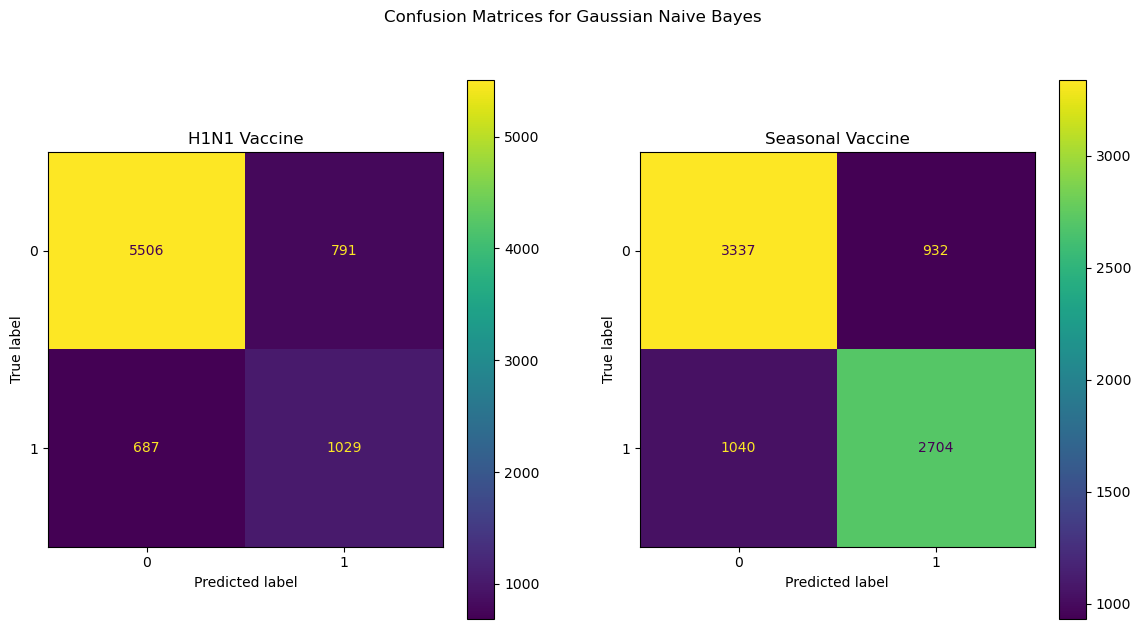

In [2307]:
# Display confusion matrices for the Catboost Model

from sklearn.metrics import ConfusionMatrixDisplay

predictions = catboost_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for Gaussian Naive Bayes')
plt.show()

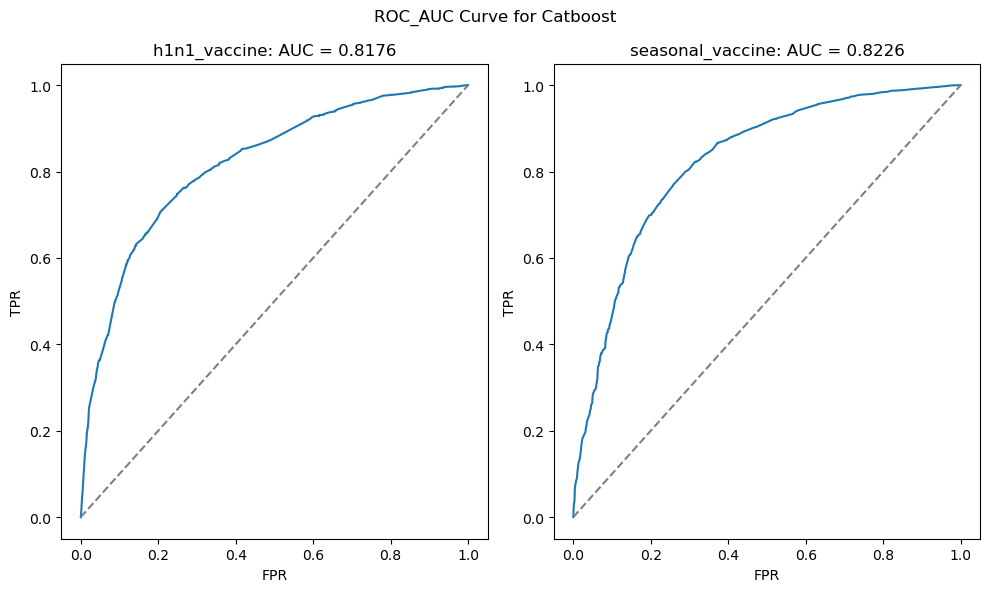

In [2308]:
#Displays the ROC_AUC Curve for the Catboost model
y_preds = catboost_grid.predict_proba(X_test)
y_preds_both = pd.DataFrame({"h1n1_vaccine":y_preds[:, 0], "seasonal_vaccine":y_preds[:, 1]}, index=Y_test.index)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle(f"ROC_AUC Curve for Catboost")

plot_roc(Y_test['h1n1_vaccine'], y_preds_both['h1n1_vaccine'], 'h1n1_vaccine',ax=ax[0])
plot_roc(Y_test['seasonal_vaccine'], y_preds_both['seasonal_vaccine'], 'seasonal_vaccine',ax=ax[1])
fig.tight_layout()

## Model Comparison

In [2309]:
# Calculate the scores of the different models on the test data
Decision_Tree_Score = xgb_grid.score(X_test, Y_test)
Random_Forest_Score = forest_grid.score(X_test, Y_test)
Knn_Score = knn_grid.score(X_test, Y_test)
Naive_Bayes_Score = naive_bayes_pipe.score(X_test, Y_test)
Cat_Boost_Score = catboost_grid.score(X_test, Y_test)

# Create a list of the scores
accuracy_score = [Random_Forest_Score, Decision_Tree_Score, Knn_Score, Naive_Bayes_Score, Cat_Boost_Score]

# Create a list of the model names
models = ["Random Forest", "XGBoost", "KNN", "Naive Bayes", "CatBoost"]

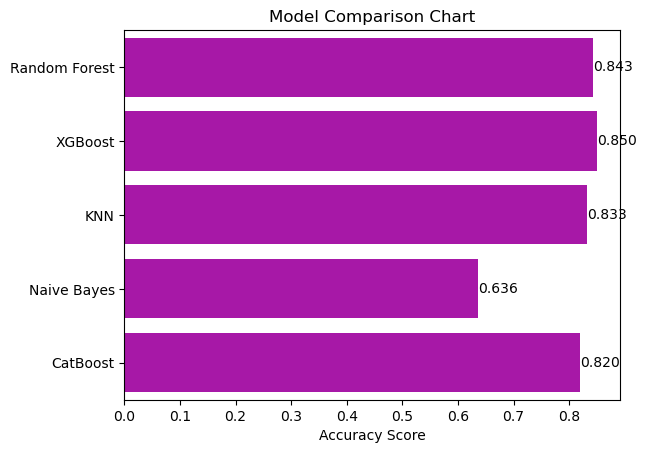

In [2310]:
# Create a bar plot with accuracy scores on the x-axis and model names on the y-axis
ax = sns.barplot(x=accuracy_score, y=models, color="m")

# Add labels to the bars displaying the accuracy scores with three decimal places
ax.bar_label(ax.containers[0], fmt='%.3f')

# Set the label for the x-axis
plt.xlabel('Accuracy Score')

# Set the label for the y-axis
plt.title('Model Comparison Chart')

#Display the plot
plt.show()

## Submission File

Pre-processing of testing features dataframe

In [2311]:
def testing_preprocessing():
    # Read the test set features data from and set the "respondent_id" column as the index
    test_features_df = pd.read_csv("test_set_features.csv", index_col="respondent_id")

    # Display the last 5 rows of the test features DataFrame
    test_features_df.tail()

    # Drop the columns "health_insurance", "employment_industry", and "employment_occupation" from the test features DataFrame
    test_features_df.drop(["health_insurance", "employment_industry", "employment_occupation"], axis = 1, inplace = True)

    # Return the preprocessed test features DataFrame
    return test_features_df

In [2214]:
test_df = testing_preprocessing()

In [2312]:
# Assign the best model found to the variable best_model
best_model = xgb_grid.best_estimator_

# Fit the best model to the features and labels data
best_model.fit(features, labels)

# Generate predictions for the test dataset using the best model and create a DataFrame with the predicted probabilities
comp_predictions = pd.DataFrame(best_model.predict_proba(test_df), index=test_df.index, columns=labels.columns)

# Save the predictions DataFrame to a CSV file
comp_predictions.to_csv('xgboost.csv')

# Display the first 10 rows of the predictions DataFrame
comp_predictions.head(10)

c:\Users\danie\anaconda3\envs\COMP4030\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.089279,0.141825
26708,0.040936,0.028461
26709,0.457137,0.734100
26710,0.593907,0.944381
26711,0.216983,0.362244
26712,0.534258,0.982101
26713,0.396713,0.428890
26714,0.100706,0.067031
26715,0.040173,0.075415
